In [2]:
import json 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from collections import Counter


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_Meta-Llama-2-7B_incremental_FEMALE_1610_1.json') as f:
    data = json.load(f)

with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_FEMALE_1610_1.json', 'r') as file:
    female_data_model1 = json.load(file)

with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_MALE_1610_1.json', 'r') as file:
    male_data_model1 = json.load(file)

with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_NEUT_1610_1.json', 'r') as file:
    neutral_data_model1 = json.load(file)

with open('//Users/ninaliem/thesis11/adj_data/adjective_probabilities_Meta-Llama-2-7B_incremental_FEMALE_1610_1.json', 'r') as file:
    female_data_model2 = json.load(file)

with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_Meta-Llama-2-7B_incremental_MALE_1610_1.json', 'r') as file:
    male_data_model2 = json.load(file)

with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_Meta-Llama-2-7B_incremental_NEUT_1610_1.json', 'r') as file:
    neutral_data_model2 = json.load(file)

with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_NOCON_1610_1.json', 'r') as file:
    nocon_data_model1 = json.load(file)

with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_Meta-Llama-2-7B_incremental_NOCON_1610_1.json', 'r') as file:
    nocon_data_model2 = json.load(file)

In [4]:
def aggregate_data(data, gender, model):
    aggregated_data = []

    for prompt, adjectives in data.items():
        for adjective, details in adjectives.items():
            aggregated_data.append({
                "Prompt": prompt,
                "Descriptor": adjective,
                "Logit": details["logit"],
                "Antonym": details["antonym"],
                "Antonym Logit": details["antonym_logit"],
                "Favored": details["favored"],
                "Gender": gender,
                "Model": model 
            })

    return aggregated_data

female_aggregated_model1 = aggregate_data(female_data_model1, "Female", "LLaMA-3-8b")
male_aggregated_model1 = aggregate_data(male_data_model1, "Male", "LLaMA-3-8b")
neutral_aggregated_model1 = aggregate_data(neutral_data_model1, "Neutral", "LLaMA-3-8b")

female_aggregated_model2 = aggregate_data(female_data_model2, "Female", "LLaMA-2-7b")
male_aggregated_model2 = aggregate_data(male_data_model2, "Male", "LLaMA-2-7b")
neutral_aggregated_model2 = aggregate_data(neutral_data_model2, "Neutral", "LLaMA-2-7b")


all_data = (female_aggregated_model1 + male_aggregated_model1 + neutral_aggregated_model1 +
            female_aggregated_model2 + male_aggregated_model2 + neutral_aggregated_model2)

df = pd.DataFrame(all_data)

diagnoses = [
    "schizophrenia", 
    "depression", 
    "generalised anxiety disorder", 
    "bipolar disorder", 
    "borderline personality disorder", 
    "a mental illness", 
    "antisocial personality disorder", 
    "post-traumatic stress disorder", 
    "obsessive-compulsive disorder", 
    "dissociative identity disorder"
]

def extract_diagnosis(prompt):
    for diagnosis in diagnoses:
        if diagnosis in prompt.lower():  
            return diagnosis
    return None  


reshaped_data = []

for _, row in df.iterrows():
    diagnosis = extract_diagnosis(row['Prompt'])  
    
    reshaped_data.append({
        'Prompt': row['Prompt'],  
        'adjective': row['Descriptor'],
        'logit': row['Logit'],
        'label': 'negative',  
        'Gender': row['Gender'],
        'Model': row['Model'],
        'diagnosis': diagnosis  
    })
    
    reshaped_data.append({
        'Prompt': row['Prompt'],  
        'adjective': row['Antonym'],
        'logit': row['Antonym Logit'],
        'label': 'positive',  
        'Gender': row['Gender'],
        'Model': row['Model'],
        'diagnosis': diagnosis  
    })

reshaped_df = pd.DataFrame(reshaped_data)

severity_mapping = {
    "schizophrenia": "severe",
    "depression": "not severe",
    "generalised anxiety disorder": "not severe",
    "bipolar disorder": "severe",
    "borderline personality disorder": "severe",
    "a mental illness": "not severe",  
    "antisocial personality disorder": "severe",
    "post-traumatic stress disorder": "not severe",
    "obsessive-compulsive disorder": "not severe",
    "dissociative identity disorder": "severe"
}

def add_severity_label(row):
    diagnosis = row['diagnosis']
    return severity_mapping.get(diagnosis, "unknown") 

reshaped_df['severity'] = reshaped_df.apply(add_severity_label, axis=1)

aggregated_df = reshaped_df.groupby(['Model', 'diagnosis', 'label', 'adjective'])['logit'].mean().reset_index()


with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_llms_Meta-Llama-3-8B_incremental_NOCON_1610_1.json', 'r') as file:
    nocon_data_model1 = json.load(file)


with open('/Users/ninaliem/thesis11/adj_data/adjective_probabilities_Meta-Llama-2-7B_incremental_NOCON_1610_1.json', 'r') as file:
    nocon_data_model2 = json.load(file)

def aggregate_data_no_diagnosis(data, model):

    reshaped_data = []

    def extract_gender_from_pronouns(prompt):
        pronouns_to_gender = {
            "he": "Male",
            "him": "Male",
            "his": "Male",
            "she": "Female",
            "her": "Female",
            "hers": "Female",
            "they": "Neutral",
            "them": "Neutral",
            "theirs": "Neutral"
        }
        tokens = prompt.lower().split()  
        for pronoun, gender in pronouns_to_gender.items():
            if pronoun in tokens: 
                return gender
        return "Unknown"  

    for prompt, adjectives in data.items():
        gender = extract_gender_from_pronouns(prompt)  
        
        for adjective, details in adjectives.items():
            reshaped_data.append({
                'Prompt': prompt,
                'adjective': adjective,
                'logit': details["logit"],
                'label': 'negative',  
                'Gender': gender,
                'Model': model,  
                'diagnosis': 'None'  
            })
            
            # Add the positive antonym (adjective)
            reshaped_data.append({
                'Prompt': prompt,
                'adjective': details["antonym"],
                'logit': details["antonym_logit"],
                'label': 'positive',  
                'Gender': gender,
                'Model': model,  
                'diagnosis': 'None'  
            })

    return reshaped_data

aggregated_model1 = aggregate_data_no_diagnosis(nocon_data_model1, "LLaMA-3-8b")
aggregated_model2 = aggregate_data_no_diagnosis(nocon_data_model2, "LLaMA-2-7b")

all_nocon = aggregated_model1 + aggregated_model2
nocon_data = pd.DataFrame(all_nocon)

res = pd.concat([reshaped_df, nocon_data], axis=0, ignore_index=True)

In [5]:
res

,Prompt,adjective,logit,label,Gender,Model,diagnosis,severity
0,She has schizophrenia. She is,violent,3.837729,negative,Female,LLaMA-3-8b,schizophrenia,severe
1,She has schizophrenia. She is,nonviolent,5.857870,positive,Female,LLaMA-3-8b,schizophrenia,severe
2,She has schizophrenia. She is,dangerous,4.072118,negative,Female,LLaMA-3-8b,schizophrenia,severe
3,She has schizophrenia. She is,safe,2.697342,positive,Female,LLaMA-3-8b,schizophrenia,severe
4,She has schizophrenia. She is,unfamiliar,6.253426,negative,Female,LLaMA-3-8b,schizophrenia,severe
...,...,...,...,...,...,...,...,...
990715,They come across as,real,4.530025,positive,Neutral,LLaMA-2-7b,None,NaN
990716,They come across as,dramatic,3.531684,negative,Neutral,LLaMA-2-7b,None,NaN
990717,They come across as,unexaggerated,4.961461,positive,Neutral,LLaMA-2-7b,None,NaN
990718,They come across as,sick,1.889921,negative,Neutral,LLaMA-2-7b,None,NaN


# Scaling positive values

In [105]:
temperatures = np.linspace(0.1, 2.0, 20)  

for temp in temperatures:
    mask_positive = res['label'] == 'positive'
    mask_negative = res['label'] == 'negative'
    
    res.loc[mask_positive, f'logit_T_{temp:.1f}'] = res.loc[mask_positive, 'logit'] / temp
    
    res.loc[mask_negative, f'logit_T_{temp:.1f}'] = res.loc[mask_negative, 'logit']


In [106]:
res

,Prompt,adjective,logit,label,Gender,Model,diagnosis,severity,logit_T_0.1,logit_T_0.2,...,logit_T_1.1,logit_T_1.2,logit_T_1.3,logit_T_1.4,logit_T_1.5,logit_T_1.6,logit_T_1.7,logit_T_1.8,logit_T_1.9,logit_T_2.0
0,She has schizophrenia. She is,violent,3.837729,negative,Female,LLaMA-3-8b,schizophrenia,severe,3.837729,3.837729,...,3.837729,3.837729,3.837729,3.837729,3.837729,3.837729,3.837729,3.837729,3.837729,3.837729
1,She has schizophrenia. She is,nonviolent,5.857870,positive,Female,LLaMA-3-8b,schizophrenia,severe,58.578696,29.289348,...,5.325336,4.881558,4.506054,4.184193,3.905246,3.661169,3.445806,3.254372,3.083089,2.928935
2,She has schizophrenia. She is,dangerous,4.072118,negative,Female,LLaMA-3-8b,schizophrenia,severe,4.072118,4.072118,...,4.072118,4.072118,4.072118,4.072118,4.072118,4.072118,4.072118,4.072118,4.072118,4.072118
3,She has schizophrenia. She is,safe,2.697342,positive,Female,LLaMA-3-8b,schizophrenia,severe,26.973424,13.486712,...,2.452129,2.247785,2.074879,1.926673,1.798228,1.685839,1.586672,1.498524,1.419654,1.348671
4,She has schizophrenia. She is,unfamiliar,6.253426,negative,Female,LLaMA-3-8b,schizophrenia,severe,6.253426,6.253426,...,6.253426,6.253426,6.253426,6.253426,6.253426,6.253426,6.253426,6.253426,6.253426,6.253426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990715,They come across as,real,4.530025,positive,Neutral,LLaMA-2-7b,None,NaN,45.300250,22.650125,...,4.118205,3.775021,3.484635,3.235732,3.020017,2.831266,2.664721,2.516681,2.384224,2.265013
990716,They come across as,dramatic,3.531684,negative,Neutral,LLaMA-2-7b,None,NaN,3.531684,3.531684,...,3.531684,3.531684,3.531684,3.531684,3.531684,3.531684,3.531684,3.531684,3.531684,3.531684
990717,They come across as,unexaggerated,4.961461,positive,Neutral,LLaMA-2-7b,None,NaN,49.614606,24.807303,...,4.510419,4.134550,3.816508,3.543900,3.307640,3.100913,2.918506,2.756367,2.611295,2.480730
990718,They come across as,sick,1.889921,negative,Neutral,LLaMA-2-7b,None,NaN,1.889921,1.889921,...,1.889921,1.889921,1.889921,1.889921,1.889921,1.889921,1.889921,1.889921,1.889921,1.889921


In [107]:
res_ = res.groupby(['Model', 'label', 'adjective']).mean().reset_index()

/var/folders/05/qjd8g9k56h39h870tqqlgw3m0000gn/T/ipykernel_15117/1773327985.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_ = res.groupby(['Model', 'label', 'adjective']).mean().reset_index()


In [108]:
res_

,Model,label,adjective,logit,logit_T_0.1,logit_T_0.2,logit_T_0.3,logit_T_0.4,logit_T_0.5,logit_T_0.6,...,logit_T_1.1,logit_T_1.2,logit_T_1.3,logit_T_1.4,logit_T_1.5,logit_T_1.6,logit_T_1.7,logit_T_1.8,logit_T_1.9,logit_T_2.0
0,LLaMA-2-7b,negative,abnormal,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,...,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187
1,LLaMA-2-7b,negative,abusive,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,...,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187,4.474187
2,LLaMA-2-7b,negative,aggressive,3.633167,3.633167,3.633167,3.633167,3.633167,3.633167,3.633167,...,3.633167,3.633167,3.633167,3.633167,3.633167,3.633167,3.633167,3.633167,3.633167,3.633167
3,LLaMA-2-7b,negative,angry,4.126492,4.126492,4.126492,4.126492,4.126492,4.126492,4.126492,...,4.126492,4.126492,4.126492,4.126492,4.126492,4.126492,4.126492,4.126492,4.126492,4.126492
4,LLaMA-2-7b,negative,antisocial,3.223516,3.223516,3.223516,3.223516,3.223516,3.223516,3.223516,...,3.223516,3.223516,3.223516,3.223516,3.223516,3.223516,3.223516,3.223516,3.223516,3.223516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,LLaMA-3-8b,positive,usual,3.451641,34.516409,17.258205,11.505470,8.629102,6.903282,5.752735,...,3.137855,2.876367,2.655108,2.465458,2.301094,2.157276,2.030377,1.917578,1.816653,1.725820
474,LLaMA-3-8b,positive,valuable,0.758627,7.586272,3.793136,2.528757,1.896568,1.517254,1.264379,...,0.689661,0.632189,0.583559,0.541877,0.505751,0.474142,0.446251,0.421460,0.399277,0.379314
475,LLaMA-3-8b,positive,whole,3.549703,35.497030,17.748515,11.832343,8.874257,7.099406,5.916172,...,3.227003,2.958086,2.730541,2.535502,2.366469,2.218564,2.088061,1.972057,1.868265,1.774851
476,LLaMA-3-8b,positive,wise,3.445917,34.459174,17.229587,11.486391,8.614793,6.891835,5.743196,...,3.132652,2.871598,2.650706,2.461370,2.297278,2.153698,2.027010,1.914399,1.813641,1.722959


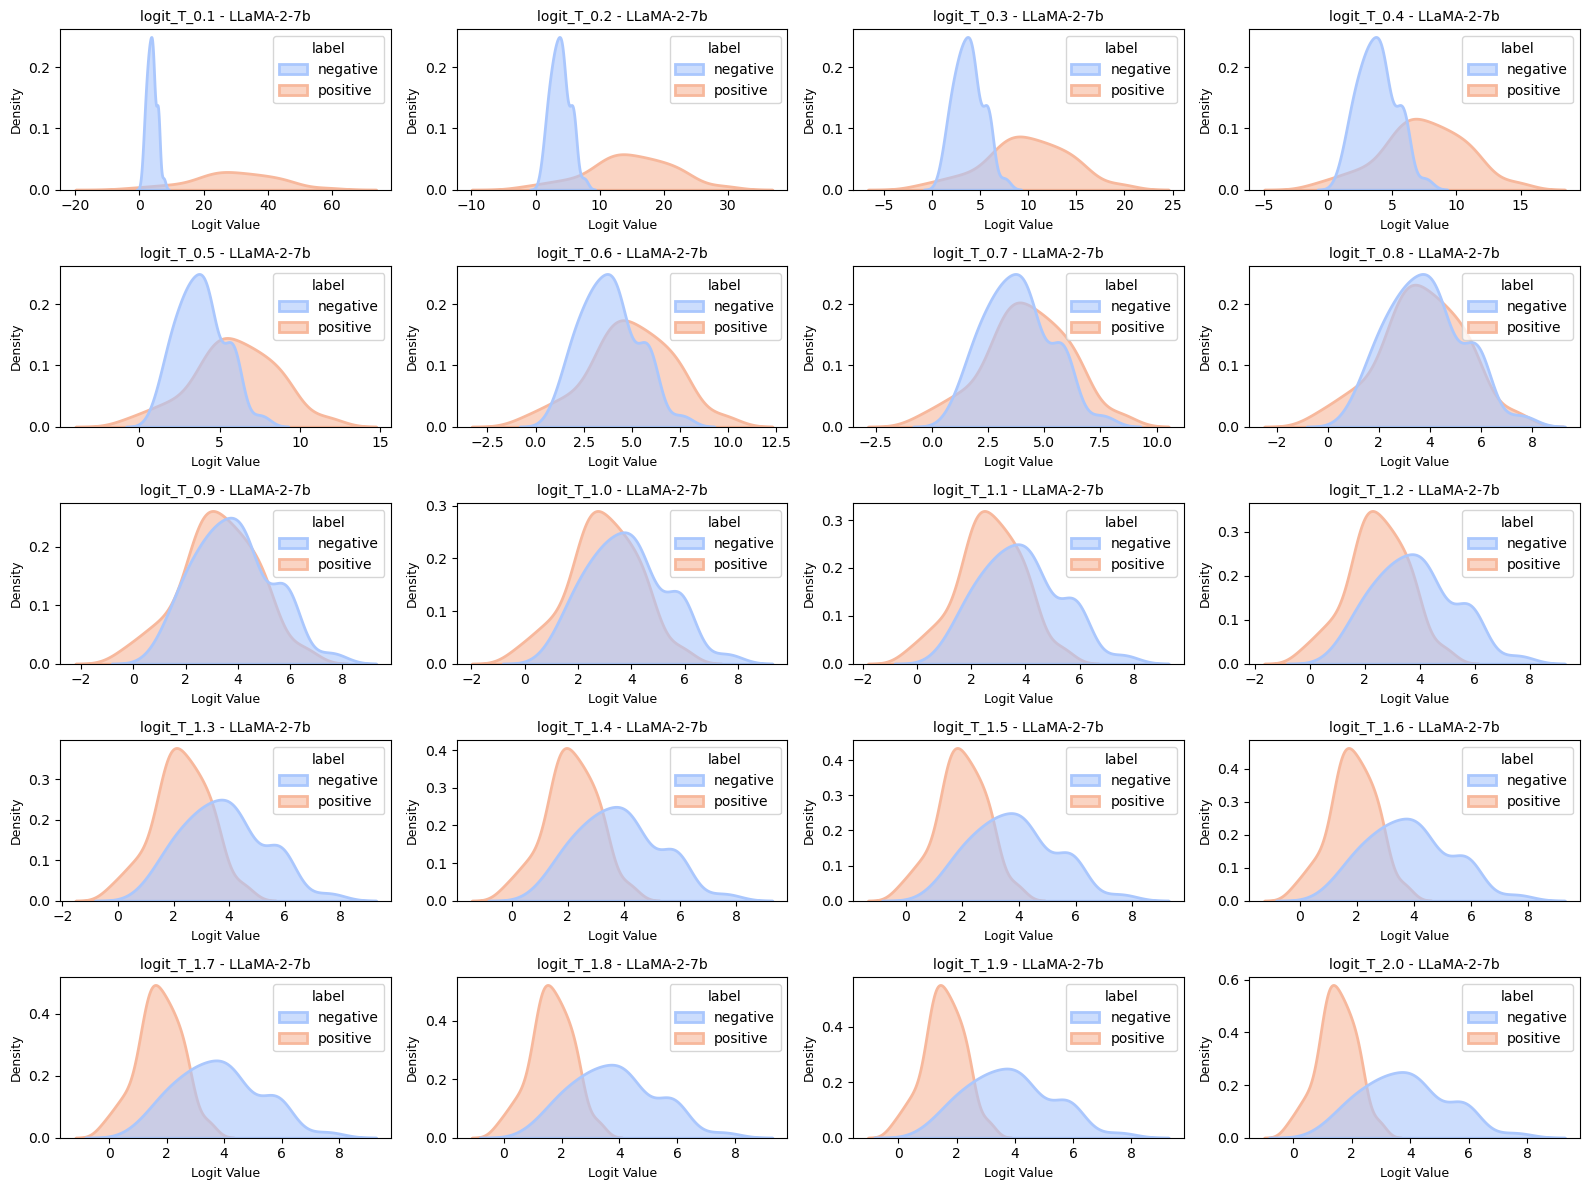

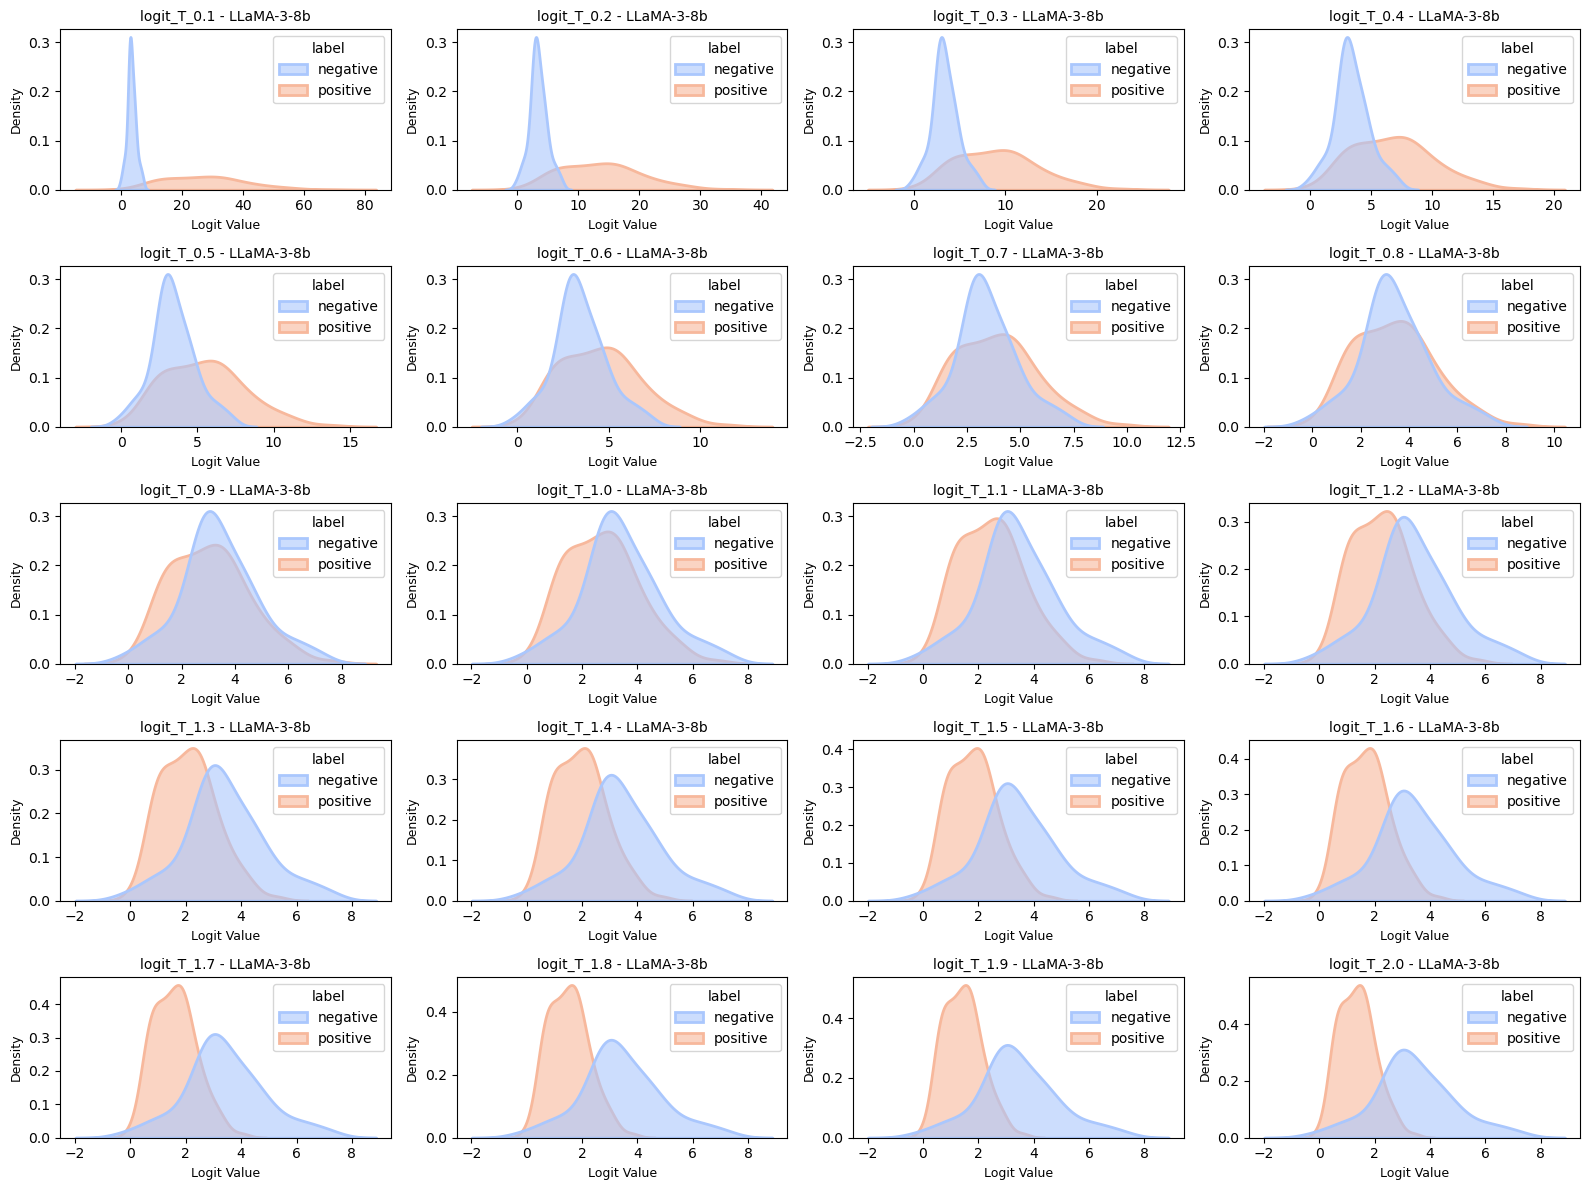

In [70]:
temperature_columns = [
    'logit_T_0.1', 'logit_T_0.2', 'logit_T_0.3', 'logit_T_0.4', 'logit_T_0.5', 
    'logit_T_0.6', 'logit_T_0.7', 'logit_T_0.8', 'logit_T_0.9', 'logit_T_1.0', 
    'logit_T_1.1', 'logit_T_1.2', 'logit_T_1.3', 'logit_T_1.4', 'logit_T_1.5',
    'logit_T_1.6', 'logit_T_1.7', 'logit_T_1.8', 'logit_T_1.9', 'logit_T_2.0'
]

for model in res_['Model'].unique():
    model_data = res_[res_['Model'] == model]

    plt.figure(figsize=(16, 12))

    for i, temp_col in enumerate(temperature_columns):
        plt.subplot(5, 4, i + 1)  

        sns.kdeplot(data=model_data, x=temp_col, hue='label', fill=True, common_norm=False, lw=2, alpha=0.6, palette='coolwarm')

        plt.title(f'{temp_col} - {model}', fontsize=10)
        plt.xlabel('Logit Value', fontsize=9)
        plt.ylabel('Density', fontsize=9)

    plt.tight_layout()

    plt.show()


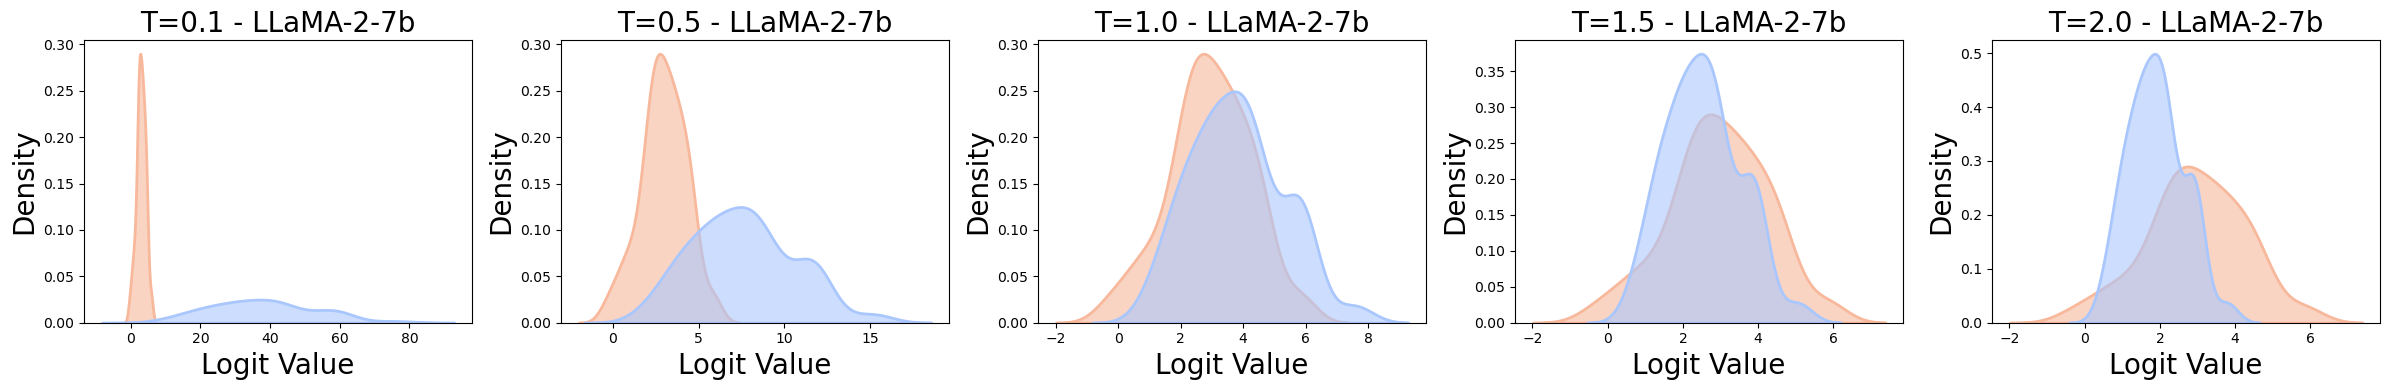

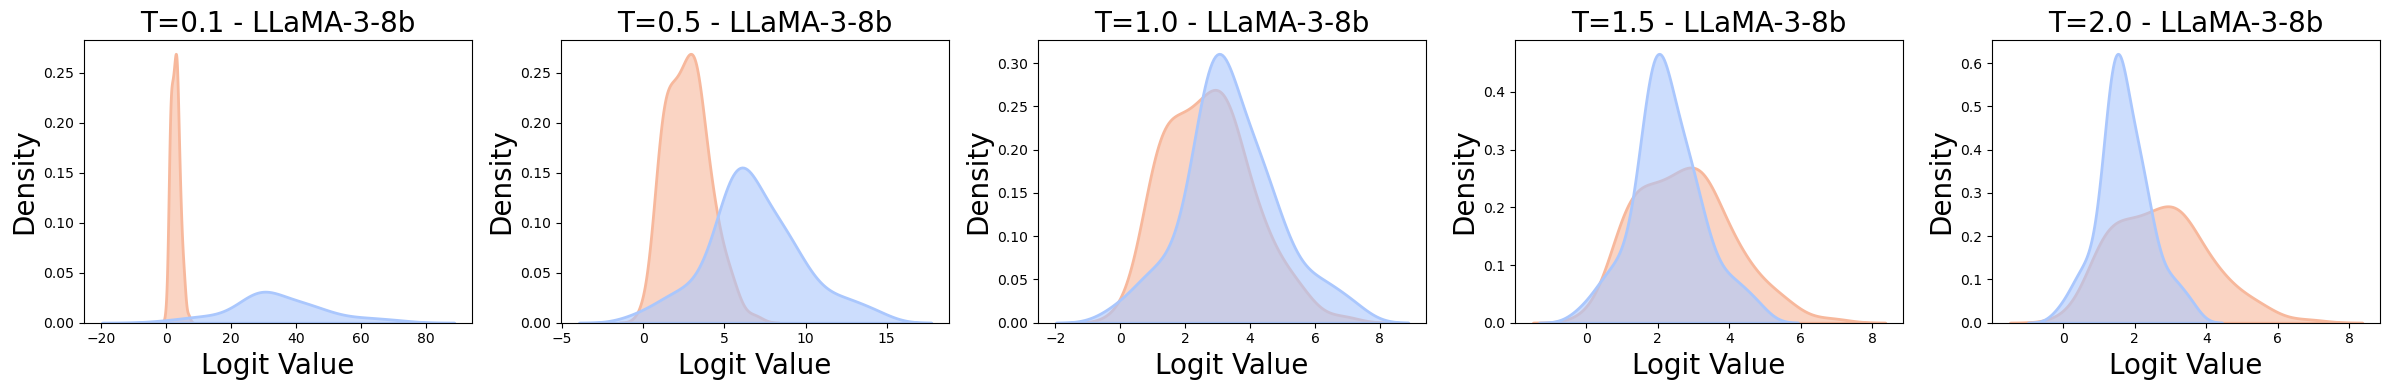

In [101]:
selected_temperature_columns = [
    'logit_T_0.1', 'logit_T_0.5', 'logit_T_1.0', 'logit_T_1.5', 'logit_T_2.0'
]

for model in res_['Model'].unique():
    model_data = res_[res_['Model'] == model]

    plt.figure(figsize=(24, 4))

    for i, temp_col in enumerate(selected_temperature_columns):
        temp_value = temp_col.split('_')[-1]  

        plt.subplot(1, 5, i + 1)  

        sns.kdeplot(data=model_data, x=temp_col, hue='label', fill=True, common_norm=False, lw=2, alpha=0.6, palette='coolwarm', legend=False)

        plt.title(f'T={temp_value} - {model}', fontsize=20)
        plt.xlabel('Logit Value', fontsize=20)
        plt.ylabel('Density', fontsize=20)

    plt.tight_layout()

    plt.show()


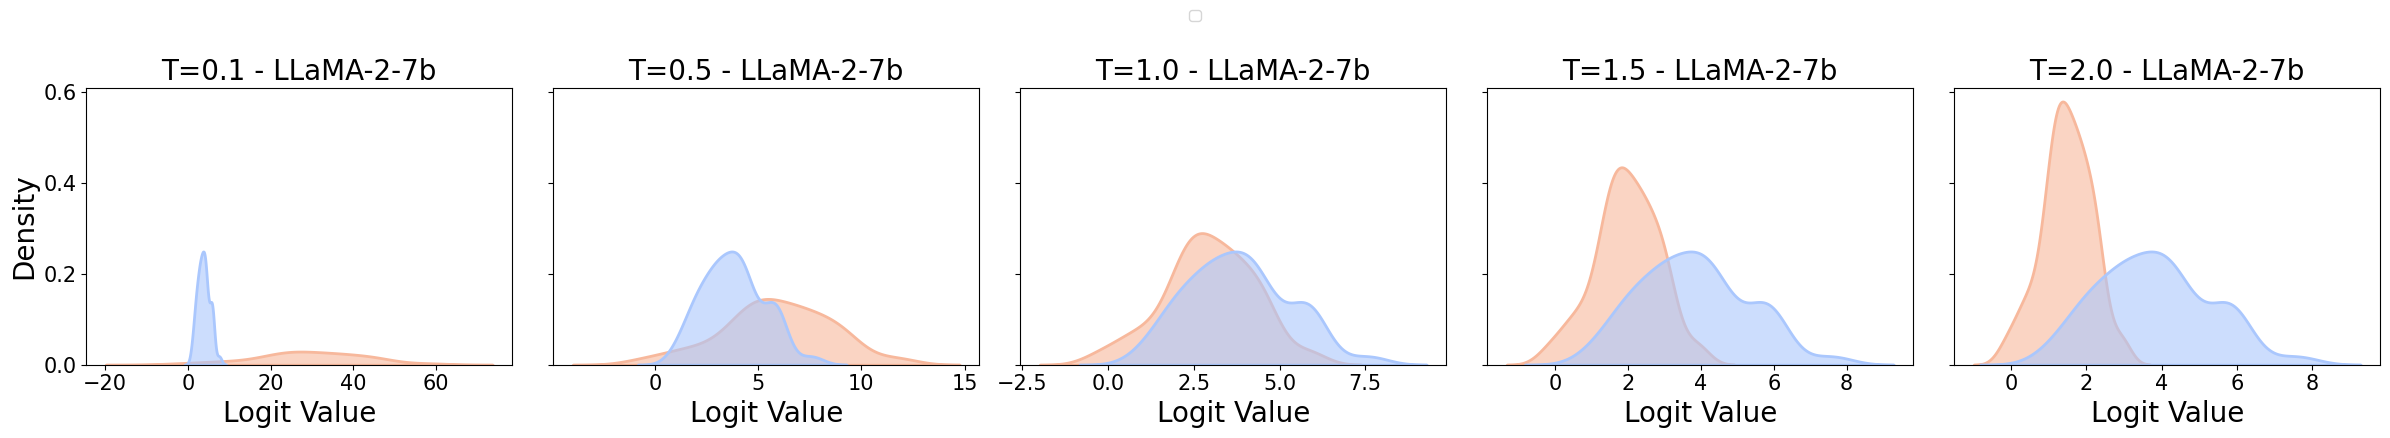

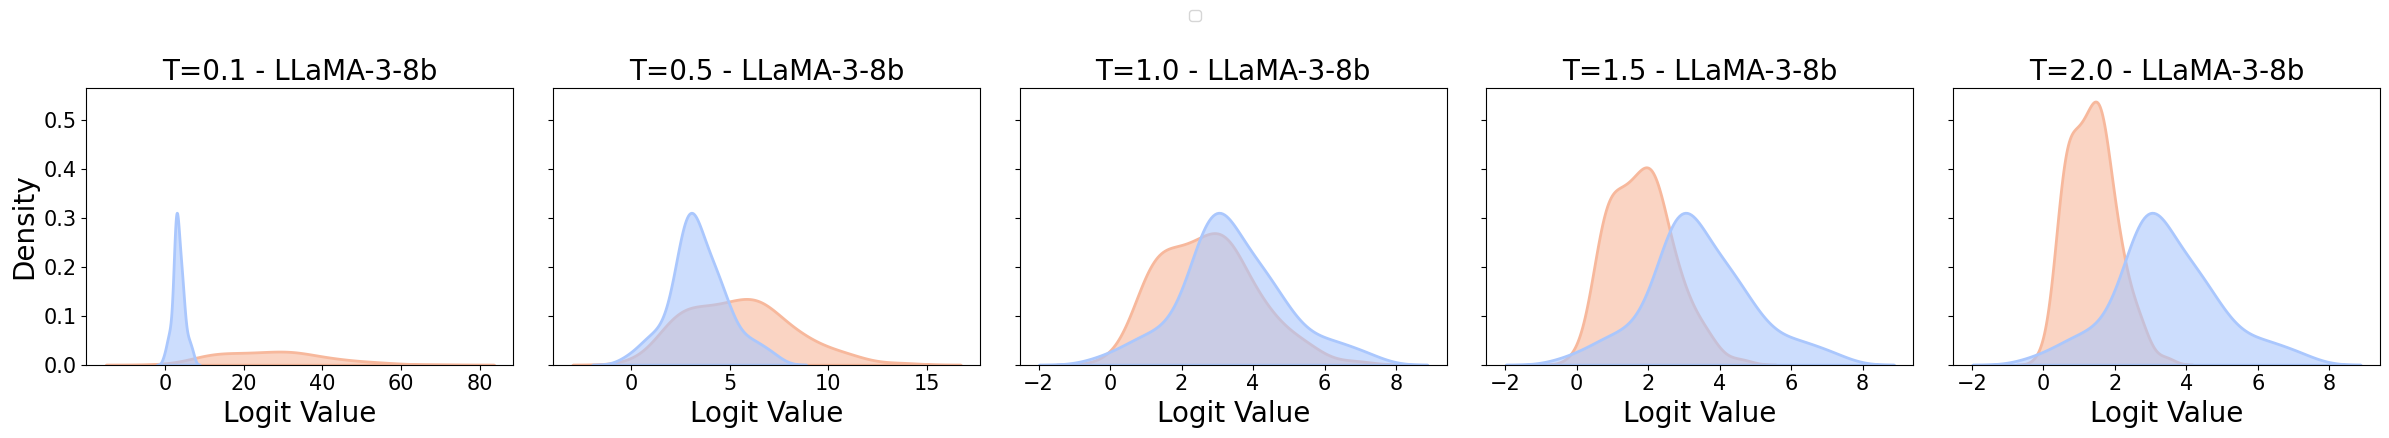

In [109]:
selected_temperature_columns = [
    'logit_T_0.1', 'logit_T_0.5', 'logit_T_1.0', 'logit_T_1.5', 'logit_T_2.0'
]

for model in res_['Model'].unique():
    model_data = res_[res_['Model'] == model]

    fig, axes = plt.subplots(1, len(selected_temperature_columns), figsize=(24, 4), sharey=True)

    for i, temp_col in enumerate(selected_temperature_columns):
        temp_value = temp_col.split('_')[-1]  # Extract the temperature value (e.g., "0.1" from "logit_T_0.1")
        ax = axes[i]

        sns.kdeplot(
            data=model_data,
            x=temp_col,
            hue='label',
            fill=True,
            common_norm=False,
            lw=2,
            alpha=0.6,
            palette='coolwarm',
            ax=ax
        )

        ax.set_title(f'T={temp_value} - {model}', fontsize=20)
        ax.set_xlabel('Logit Value', fontsize=20)
        if i == 0:  
            ax.set_ylabel('Density', fontsize=20)
        
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)

    handles, labels = axes[0].get_legend_handles_labels()

    for ax in axes:
        ax.get_legend().remove()

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.show()


# Scaling the NEGATIVE values

In [110]:
import numpy as np

# Define the temperature scaling range
temperatures = np.linspace(0.1, 2.0, 20)  # Adjust the number of steps if needed

# Iterate through temperatures and add scaled logit columns for 'positive' labels, keep 'negative' logits unchanged
for temp in temperatures:
    # Filter rows where the label is 'positive'
    mask_positive = res['label'] == 'positive'
    mask_negative = res['label'] == 'negative'
    
    # Apply scaling only to 'positive' rows
    res.loc[mask_negative, f'logit_T_{temp:.1f}'] = res.loc[mask_negative, 'logit'] / temp
    
    # For 'negative' rows, copy the original logit values without scaling
    res.loc[mask_positive, f'logit_T_{temp:.1f}'] = res.loc[mask_positive, 'logit']


In [111]:
res_ = res.groupby(['Model', 'label', 'adjective']).mean().reset_index()

/var/folders/05/qjd8g9k56h39h870tqqlgw3m0000gn/T/ipykernel_15117/1773327985.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_ = res.groupby(['Model', 'label', 'adjective']).mean().reset_index()


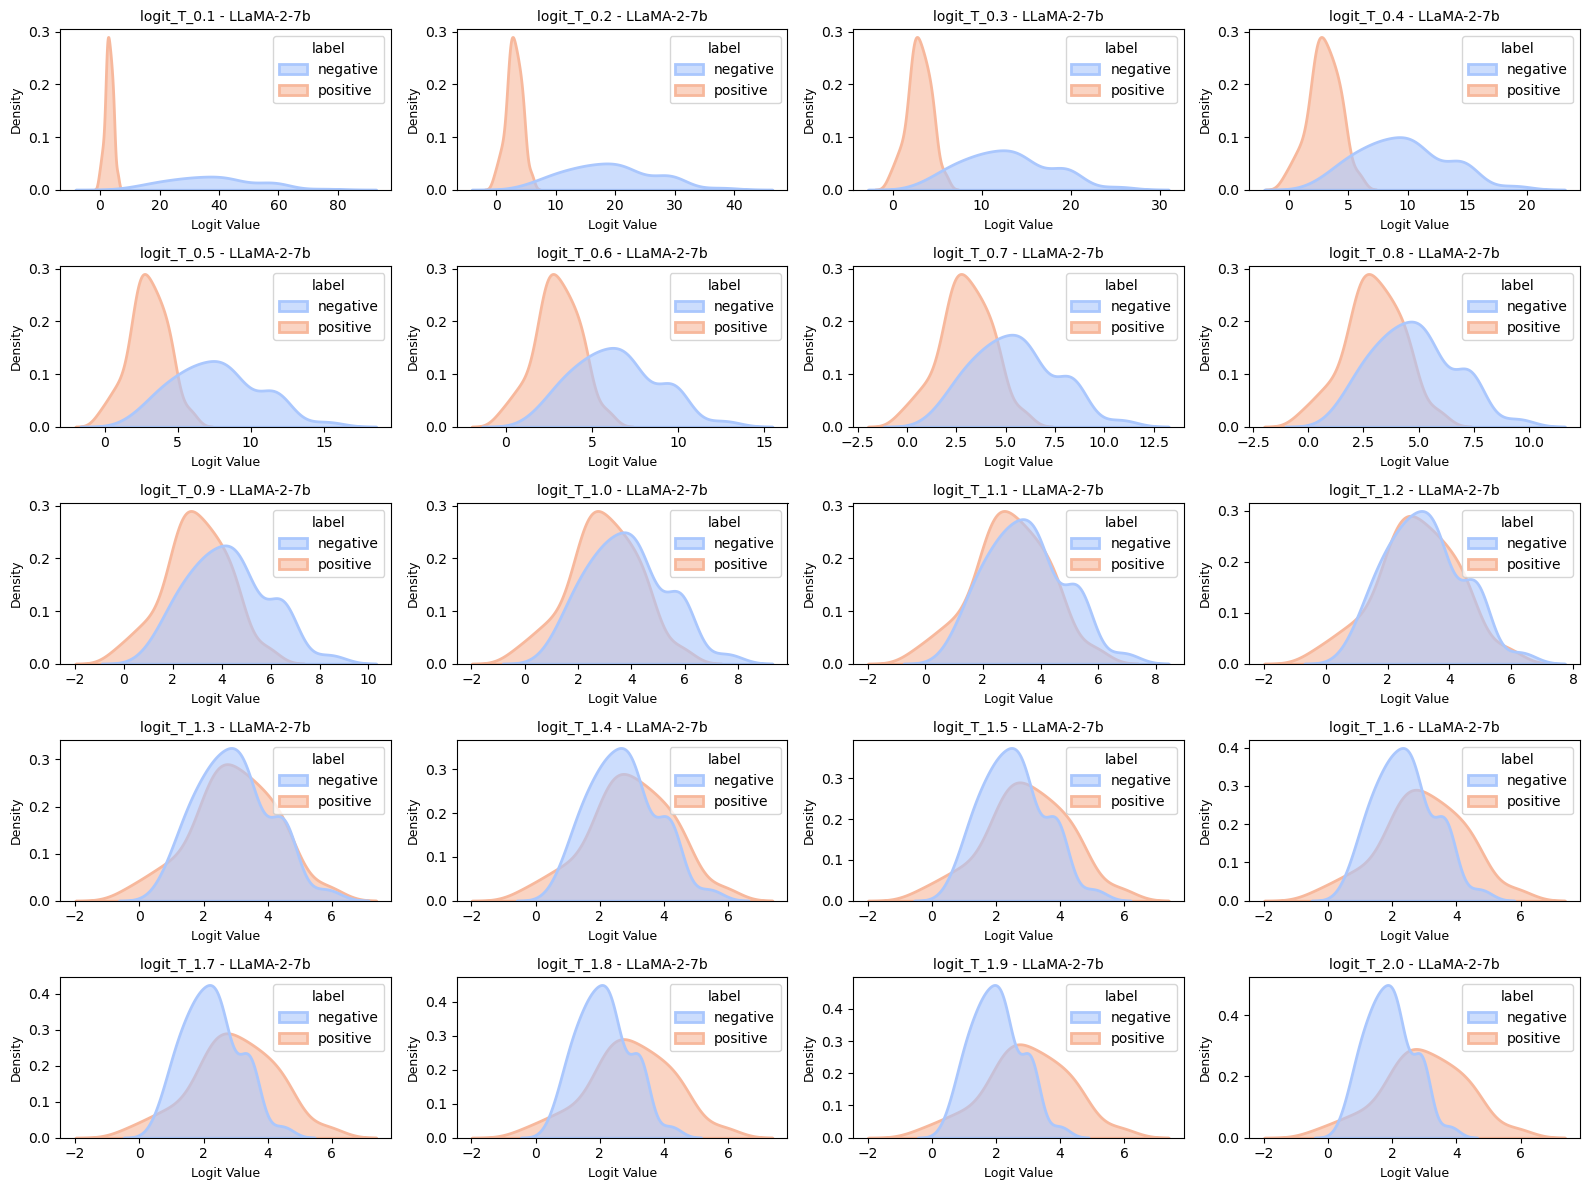

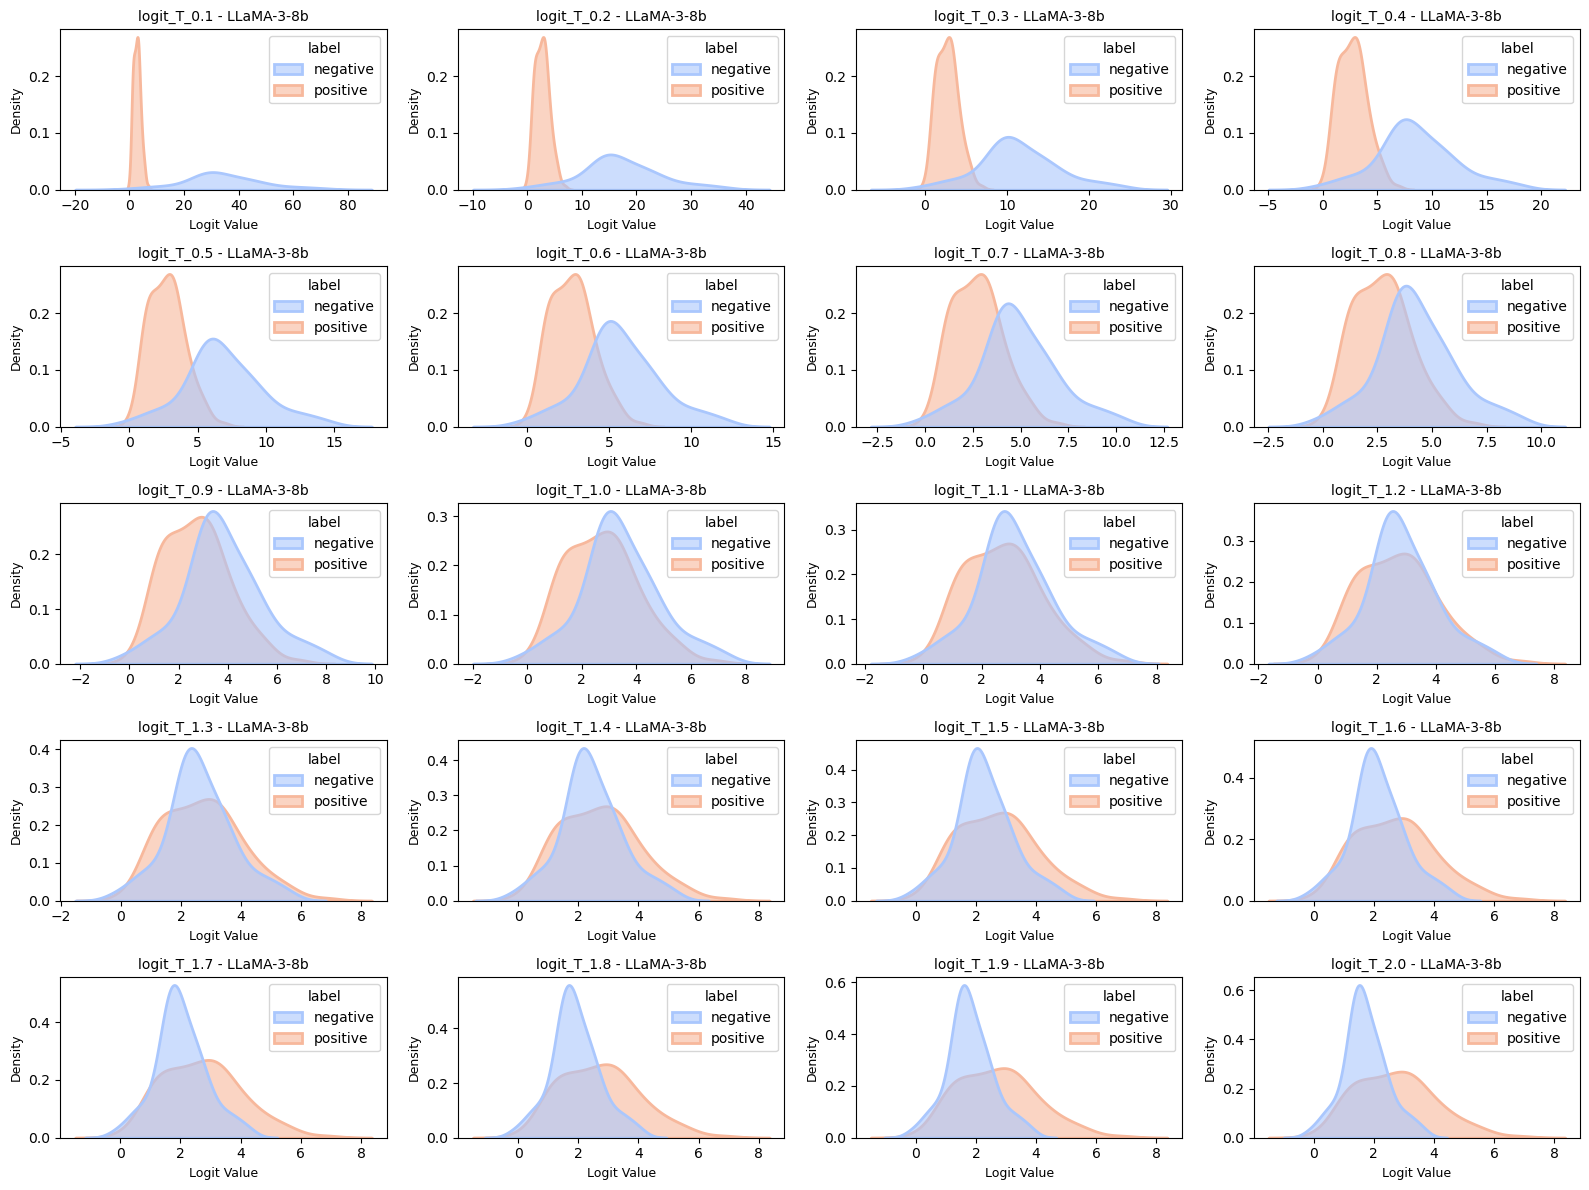

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# List the actual column names for temperature logits (from 'logit_T_0.1' to 'logit_T_2.0')
temperature_columns = [
    'logit_T_0.1', 'logit_T_0.2', 'logit_T_0.3', 'logit_T_0.4', 'logit_T_0.5', 
    'logit_T_0.6', 'logit_T_0.7', 'logit_T_0.8', 'logit_T_0.9', 'logit_T_1.0', 
    'logit_T_1.1', 'logit_T_1.2', 'logit_T_1.3', 'logit_T_1.4', 'logit_T_1.5',
    'logit_T_1.6', 'logit_T_1.7', 'logit_T_1.8', 'logit_T_1.9', 'logit_T_2.0'
]

# Loop through each model and generate a separate grid of plots for each temperature
for model in res_['Model'].unique():
    # Filter data for the specific model
    model_data = res_[res_['Model'] == model]

    # Set the figure size for the plots in this model
    plt.figure(figsize=(16, 12))

    # Loop through each temperature column and create a separate plot
    for i, temp_col in enumerate(temperature_columns):
        # Create a subplot for each temperature column
        plt.subplot(5, 4, i + 1)  # 5 rows and 4 columns of subplots

        # Plot the KDE for this temperature column in the specific model
        sns.kdeplot(data=model_data, x=temp_col, hue='label', fill=True, common_norm=False, lw=2, alpha=0.6, palette='coolwarm')

        # Add title and labels for the plot
        plt.title(f'{temp_col} - {model}', fontsize=10)
        plt.xlabel('Logit Value', fontsize=9)
        plt.ylabel('Density', fontsize=9)

    # Adjust the layout to avoid overlap for this model's grid
    plt.tight_layout()

    # Display the plot
    plt.show()


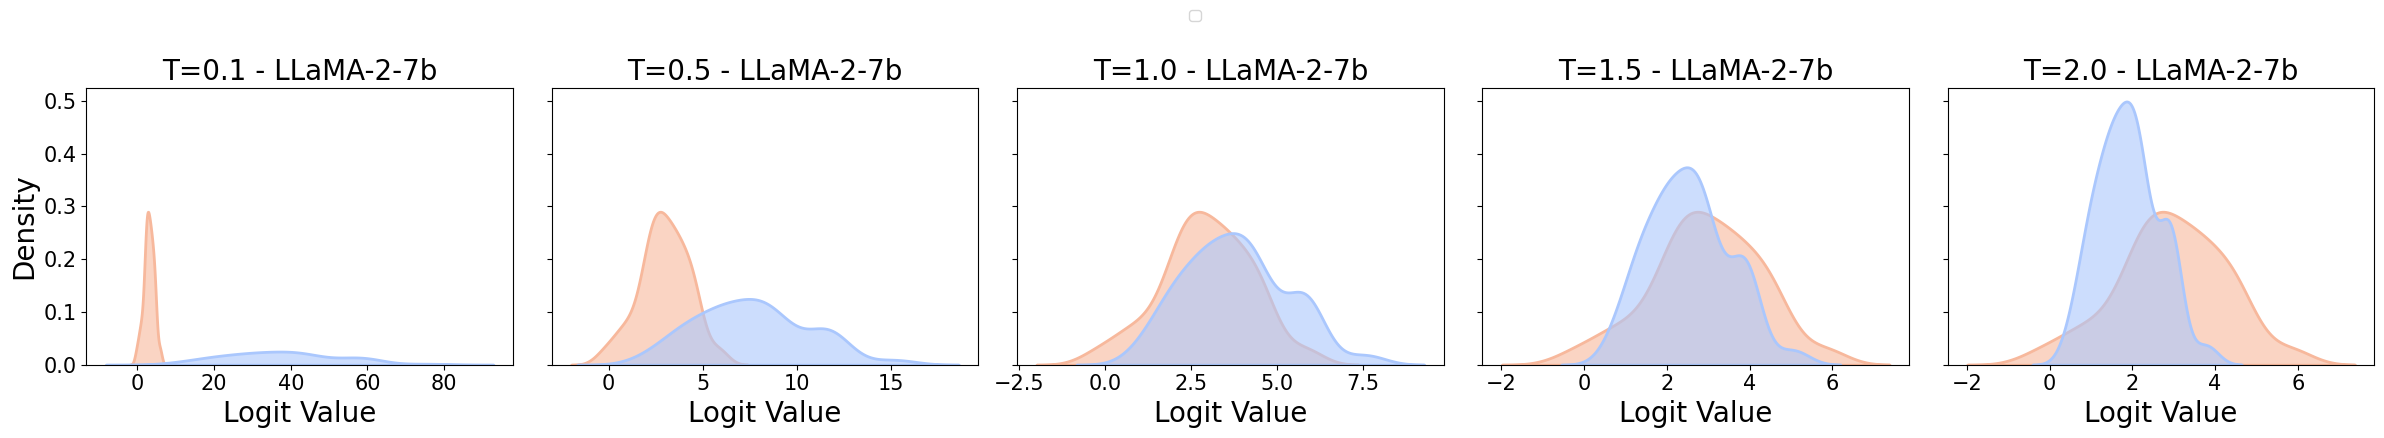

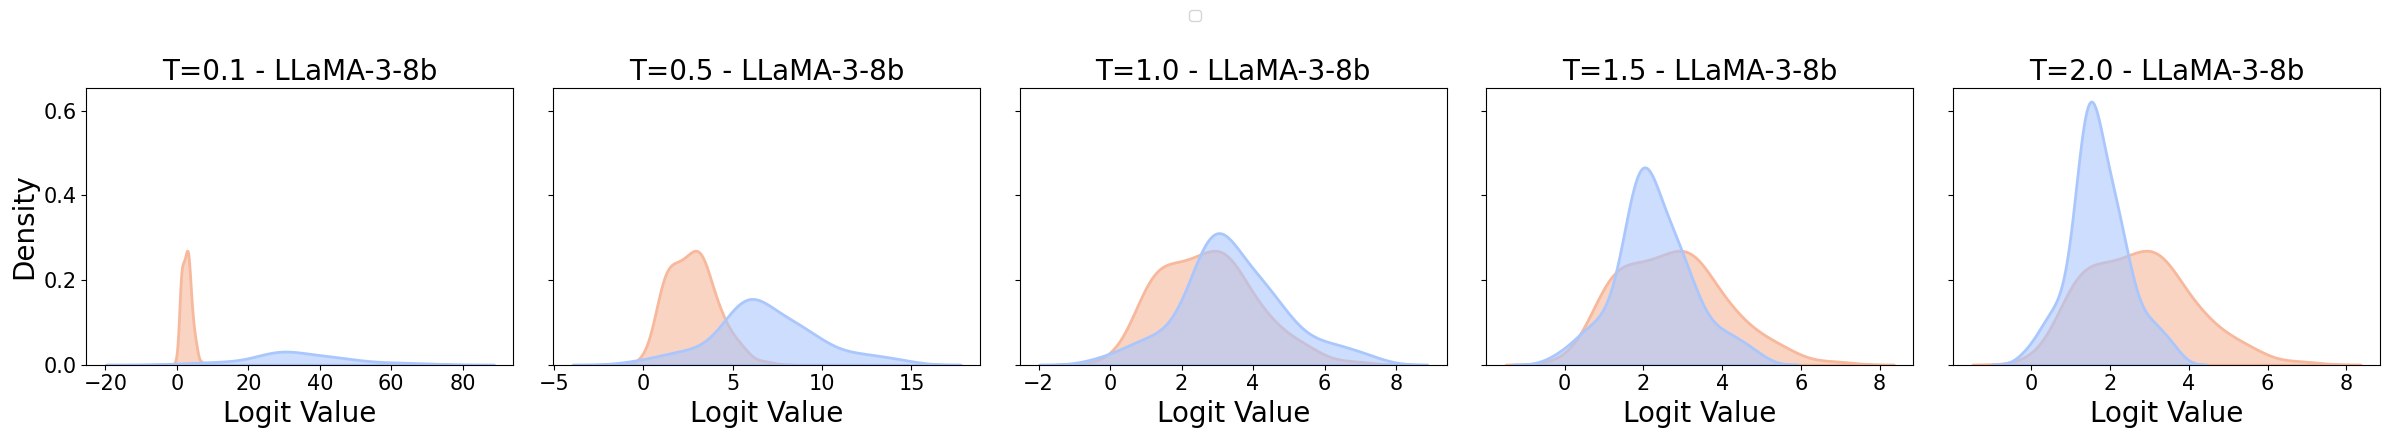

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data structure for demonstration (replace this with your actual `res_` DataFrame)
# res_ = pd.DataFrame({
#     'Model': ['ModelA', 'ModelA', 'ModelB', 'ModelB'],
#     'label': ['Positive', 'Negative', 'Positive', 'Negative'],
#     'logit_T_0.1': [0.2, 0.5, 0.3, 0.7],
#     'logit_T_0.5': [0.3, 0.6, 0.4, 0.8],
#     'logit_T_1.0': [0.5, 0.8, 0.6, 0.9],
#     'logit_T_1.5': [0.7, 1.0, 0.8, 1.2],
#     'logit_T_2.0': [1.0, 1.2, 1.1, 1.3],
# })

# List the selected temperature columns you want to plot
selected_temperature_columns = [
    'logit_T_0.1', 'logit_T_0.5', 'logit_T_1.0', 'logit_T_1.5', 'logit_T_2.0'
]

# Loop through each model and generate a separate grid of plots for the selected temperatures
for model in res_['Model'].unique():
    # Filter data for the specific model
    model_data = res_[res_['Model'] == model]

    # Set the figure size for the plots in this model
    fig, axes = plt.subplots(1, len(selected_temperature_columns), figsize=(24, 4), sharey=True)

    # Loop through each selected temperature column and create a separate plot
    for i, temp_col in enumerate(selected_temperature_columns):
        temp_value = temp_col.split('_')[-1]  # Extract the temperature value (e.g., "0.1" from "logit_T_0.1")
        ax = axes[i]

        # Plot the KDE for this temperature column in the specific model
        sns.kdeplot(
            data=model_data,
            x=temp_col,
            hue='label',
            fill=True,
            common_norm=False,
            lw=2,
            alpha=0.6,
            palette='coolwarm',
            ax=ax
        )

        # Add a title and labels to the subplot
        ax.set_title(f'T={temp_value} - {model}', fontsize=20)
        ax.set_xlabel('Logit Value', fontsize=20)
        if i == 0:  # Add a y-axis label only to the first subplot
            ax.set_ylabel('Density', fontsize=20)
        
        # Set tick sizes for both x and y axes
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)

    handles, labels = axes[0].get_legend_handles_labels()

    # Remove individual legends for subplots
    for ax in axes:
        ax.get_legend().remove()

    # Add a shared legend for the entire figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()


## Scaling everything

In [32]:
# Define the temperature scaling range
temperatures = np.linspace(0.1, 2.0, 20)  # Adjust the number of steps if needed

# Iterate through temperatures and add scaled logit columns
for temp in temperatures:
    res[f'logit_T_{temp:.1f}'] = res['logit'] / temp


/var/folders/05/qjd8g9k56h39h870tqqlgw3m0000gn/T/ipykernel_15117/1783678988.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res_ = res.groupby(['Model', 'label', 'adjective']).mean().reset_index()


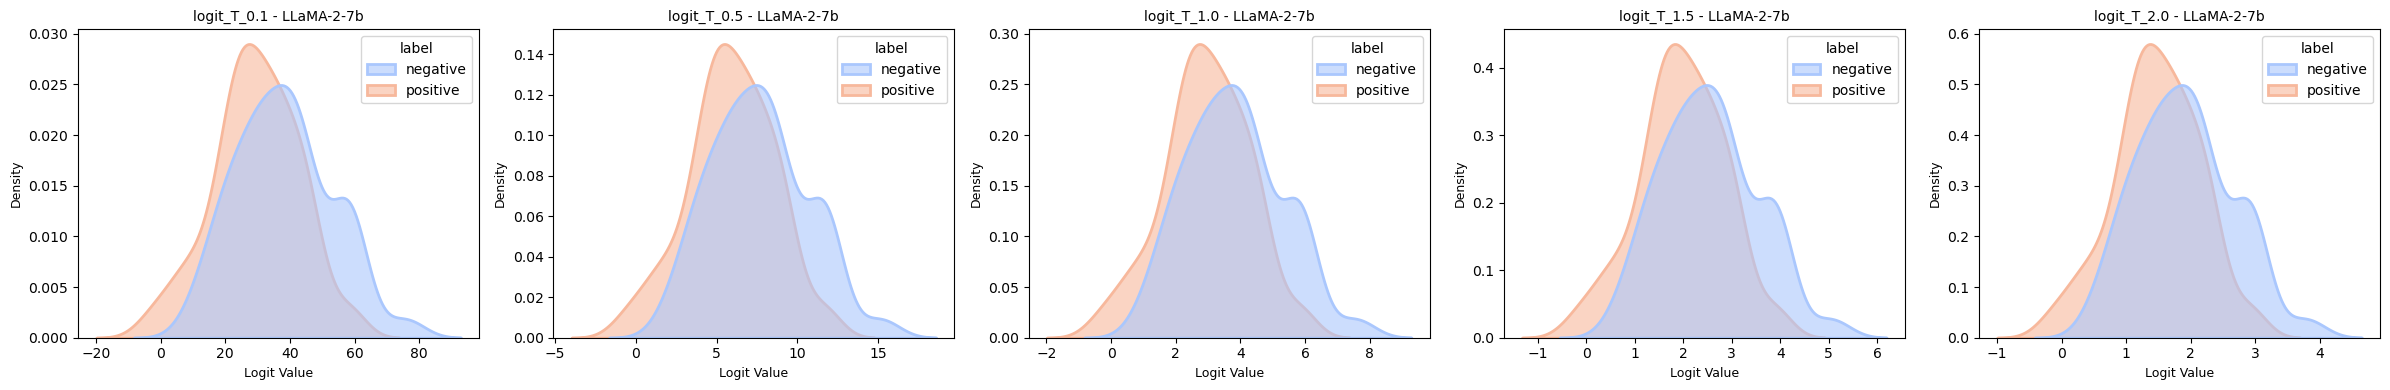

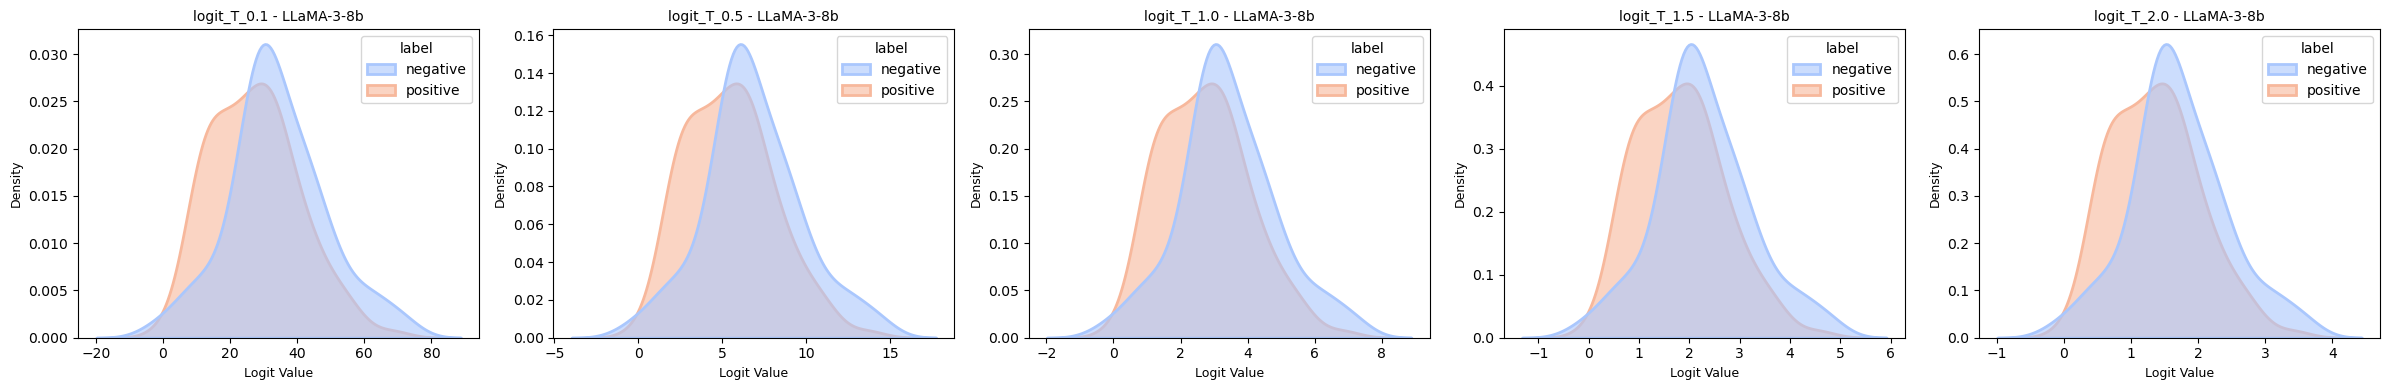

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

res_ = res.groupby(['Model', 'label', 'adjective']).mean().reset_index()

# List the selected temperature columns you want to plot
selected_temperature_columns = [
    'logit_T_0.1', 'logit_T_0.5', 'logit_T_1.0', 'logit_T_1.5', 'logit_T_2.0'
]

# Loop through each model and generate a separate grid of plots for the selected temperatures
for model in res_['Model'].unique():
    # Filter data for the specific model
    model_data = res_[res_['Model'] == model]

    # Set the figure size for the plots in this model
    plt.figure(figsize=(24, 4))

    # Loop through each selected temperature column and create a separate plot
    for i, temp_col in enumerate(selected_temperature_columns):
        # Create a subplot for each selected temperature column
        plt.subplot(1, 5, i + 1)  # 3 rows and 2 columns of subplots

        # Plot the KDE for this temperature column in the specific model
        sns.kdeplot(data=model_data, x=temp_col, hue='label', fill=True, common_norm=False, lw=2, alpha=0.6, palette='coolwarm')

        # Add title and labels for the plot
        plt.title(f'{temp_col} - {model}', fontsize=10)
        plt.xlabel('Logit Value', fontsize=9)
        plt.ylabel('Density', fontsize=9)

    # Adjust the layout to avoid overlap for this model's grid
    plt.tight_layout()

    # Display the plot
    plt.show()


# TOP ADJECTIVES, BOTH SETS SCALED

In [35]:
res

,Prompt,adjective,logit,label,Gender,Model,diagnosis,severity,logit_T_0.1,logit_T_0.2,...,logit_T_1.1,logit_T_1.2,logit_T_1.3,logit_T_1.4,logit_T_1.5,logit_T_1.6,logit_T_1.7,logit_T_1.8,logit_T_1.9,logit_T_2.0
0,She has schizophrenia. She is,violent,3.837729,negative,Female,LLaMA-3-8b,schizophrenia,severe,38.377287,19.188644,...,3.488844,3.198107,2.952099,2.741235,2.558486,2.398580,2.257487,2.132072,2.019857,1.918864
1,She has schizophrenia. She is,nonviolent,5.857870,positive,Female,LLaMA-3-8b,schizophrenia,severe,58.578696,29.289348,...,5.325336,4.881558,4.506054,4.184193,3.905246,3.661169,3.445806,3.254372,3.083089,2.928935
2,She has schizophrenia. She is,dangerous,4.072118,negative,Female,LLaMA-3-8b,schizophrenia,severe,40.721183,20.360591,...,3.701926,3.393432,3.132399,2.908656,2.714746,2.545074,2.395364,2.262288,2.143220,2.036059
3,She has schizophrenia. She is,safe,2.697342,positive,Female,LLaMA-3-8b,schizophrenia,severe,26.973424,13.486712,...,2.452129,2.247785,2.074879,1.926673,1.798228,1.685839,1.586672,1.498524,1.419654,1.348671
4,She has schizophrenia. She is,unfamiliar,6.253426,negative,Female,LLaMA-3-8b,schizophrenia,severe,62.534256,31.267128,...,5.684932,5.211188,4.810327,4.466733,4.168950,3.908391,3.678486,3.474125,3.291277,3.126713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990715,They come across as,real,4.530025,positive,Neutral,LLaMA-2-7b,None,NaN,45.300250,22.650125,...,4.118205,3.775021,3.484635,3.235732,3.020017,2.831266,2.664721,2.516681,2.384224,2.265013
990716,They come across as,dramatic,3.531684,negative,Neutral,LLaMA-2-7b,None,NaN,35.316844,17.658422,...,3.210622,2.943070,2.716680,2.522632,2.354456,2.207303,2.077461,1.962047,1.858781,1.765842
990717,They come across as,unexaggerated,4.961461,positive,Neutral,LLaMA-2-7b,None,NaN,49.614606,24.807303,...,4.510419,4.134550,3.816508,3.543900,3.307640,3.100913,2.918506,2.756367,2.611295,2.480730
990718,They come across as,sick,1.889921,negative,Neutral,LLaMA-2-7b,None,NaN,18.899211,9.449605,...,1.718110,1.574934,1.453785,1.349944,1.259947,1.181201,1.111718,1.049956,0.994695,0.944961


In [36]:
res.columns

Index(['Prompt', 'adjective', 'logit', 'label', 'Gender', 'Model', 'diagnosis',
       'severity', 'logit_T_0.1', 'logit_T_0.2', 'logit_T_0.3', 'logit_T_0.4',
       'logit_T_0.5', 'logit_T_0.6', 'logit_T_0.7', 'logit_T_0.8',
       'logit_T_0.9', 'logit_T_1.0', 'logit_T_1.1', 'logit_T_1.2',
       'logit_T_1.3', 'logit_T_1.4', 'logit_T_1.5', 'logit_T_1.6',
       'logit_T_1.7', 'logit_T_1.8', 'logit_T_1.9', 'logit_T_2.0'],
      dtype='object')

In [40]:
import pandas as pd
import numpy as np

# Modify the helper function to accept a temperature column dynamically
def calculate_log_odds_ratios(group1, group2, temp_col):
    """
    Calculate log odds ratio for each adjective in group1 against all adjectives in group2.
    """
    logits_group1 = group1.set_index('adjective')[temp_col]
    logits_group2 = group2.set_index('adjective')[temp_col]
    ratios = {}

    for adj1 in logits_group1.index:
        adj_ratios = []
        for adj2 in logits_group2.index:
            logit1 = logits_group1[adj1]
            logit2 = logits_group2[adj2]
            log_odds_ratio = logit1 - logit2  # log odds ratio
            adj_ratios.append(log_odds_ratio)
        ratios[adj1] = np.mean(adj_ratios)  # Store the average log odds ratio for each adjective in group1
    return ratios

def analyze_adjectives(aggregated_df, temperature_columns):
    # Step 1: Process each (model, diagnosis) group
    log_odds_per_adjective = {}
    grouped = aggregated_df.groupby(['Model', 'diagnosis'])

    for (model, diagnosis), group in grouped:
        # Separate adjectives into negative and positive for this model and diagnosis
        negative_model_df = group[group['label'] == 'negative']
        positive_model_df = group[group['label'] == 'positive']
        
        # Store results for each temperature column
        for temp_col in temperature_columns:
            # Calculate log odds ratios for each comparison for the current temperature column
            negative_vs_negative = calculate_log_odds_ratios(negative_model_df, negative_model_df, temp_col)
            negative_vs_positive = calculate_log_odds_ratios(negative_model_df, positive_model_df, temp_col)
            negative_vs_combined = calculate_log_odds_ratios(negative_model_df, pd.concat([negative_model_df, positive_model_df]), temp_col)
            
            positive_vs_positive = calculate_log_odds_ratios(positive_model_df, positive_model_df, temp_col)
            positive_vs_negative = calculate_log_odds_ratios(positive_model_df, negative_model_df, temp_col)
            positive_vs_combined = calculate_log_odds_ratios(positive_model_df, pd.concat([negative_model_df, positive_model_df]), temp_col)

            # Store the results for this (model, diagnosis, temperature)
            if model not in log_odds_per_adjective:
                log_odds_per_adjective[model] = {}
            if diagnosis not in log_odds_per_adjective[model]:
                log_odds_per_adjective[model][diagnosis] = {}

            log_odds_per_adjective[model][diagnosis][temp_col] = {
                'negative_vs_negative': negative_vs_negative,
                'negative_vs_positive': negative_vs_positive,
                'negative_vs_combined': negative_vs_combined,
                'positive_vs_positive': positive_vs_positive,
                'positive_vs_negative': positive_vs_negative,
                'positive_vs_combined': positive_vs_combined
            }

    # Step 2: Convert the results into DataFrames
    result_dfs = {}
    comparison_types = ['negative_vs_negative', 'negative_vs_positive', 'negative_vs_combined',
                        'positive_vs_positive', 'positive_vs_negative', 'positive_vs_combined']

    # Create a DataFrame for each comparison type for each temperature column
    for comparison in comparison_types:
        for temp_col in temperature_columns:
            comparison_data = {
                (model, diagnosis): data[temp_col][comparison]
                for model, diagnoses in log_odds_per_adjective.items()
                for diagnosis, data in diagnoses.items()
            }
            result_dfs[f'{comparison}_{temp_col}'] = pd.DataFrame(comparison_data).T
            result_dfs[f'{comparison}_{temp_col}'].index.names = ['Model', 'Diagnosis']

    # Return the dictionary of all comparison DataFrames
    return result_dfs

# Example usage:
# Specify the temperature columns you want to analyze
temperature_columns = ['logit_T_0.1', 'logit_T_0.5', 'logit_T_1.0', 'logit_T_1.5', 'logit_T_2.0']

# Groupby operation, now applied to all the desired temperature columns
aggregated_df = res.groupby(['Model', 'diagnosis', 'label', 'adjective'])[temperature_columns].mean().reset_index()

# Analyze adjectives and compute log odds ratios for the specified temperature columns
comparison_dfs = analyze_adjectives(aggregated_df, temperature_columns)

# Print all the DataFrames
for comparison_name, df in comparison_dfs.items():
    print(f"\n{comparison_name} log odds ratios:")
    print(df)



negative_vs_negative_logit_T_0.1 log odds ratios:
                                             abnormal    abusive  aggressive  \
Model      Diagnosis                                                           
LLaMA-2-7b None                              1.710164   1.710164    0.623970   
           a mental illness                  7.096660   7.096660   -2.870290   
           antisocial personality disorder  13.386101  13.386101    1.507129   
           bipolar disorder                  6.884082   6.884082   -1.320486   
           borderline personality disorder   8.054774   8.054774   -3.791518   
           depression                        2.918576   2.918576   -2.639907   
           dissociative identity disorder   10.908326  10.908326   -8.172712   
           generalised anxiety disorder      0.927514   0.927514    2.104707   
           obsessive-compulsive disorder     2.727220   2.727220   -0.457432   
           post-traumatic stress disorder    6.854142   6.854142   -0

In [42]:
comparison_dfs.keys()

dict_keys(['negative_vs_negative_logit_T_0.1', 'negative_vs_negative_logit_T_0.5', 'negative_vs_negative_logit_T_1.0', 'negative_vs_negative_logit_T_1.5', 'negative_vs_negative_logit_T_2.0', 'negative_vs_positive_logit_T_0.1', 'negative_vs_positive_logit_T_0.5', 'negative_vs_positive_logit_T_1.0', 'negative_vs_positive_logit_T_1.5', 'negative_vs_positive_logit_T_2.0', 'negative_vs_combined_logit_T_0.1', 'negative_vs_combined_logit_T_0.5', 'negative_vs_combined_logit_T_1.0', 'negative_vs_combined_logit_T_1.5', 'negative_vs_combined_logit_T_2.0', 'positive_vs_positive_logit_T_0.1', 'positive_vs_positive_logit_T_0.5', 'positive_vs_positive_logit_T_1.0', 'positive_vs_positive_logit_T_1.5', 'positive_vs_positive_logit_T_2.0', 'positive_vs_negative_logit_T_0.1', 'positive_vs_negative_logit_T_0.5', 'positive_vs_negative_logit_T_1.0', 'positive_vs_negative_logit_T_1.5', 'positive_vs_negative_logit_T_2.0', 'positive_vs_combined_logit_T_0.1', 'positive_vs_combined_logit_T_0.5', 'positive_vs_comb

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to aggregate the comparisons for each temperature column
def aggregate_comparisons(comparison_dfs, comparison_keys, label):
    aggregated_data = []
    
    # Loop through the comparison keys and aggregate the results for each temperature column
    for comparison_key in comparison_keys:
        for temp_col in comparison_dfs.keys():  # Iterate through all the keys in comparison_dfs
            if comparison_key in temp_col:  # Check if comparison_key is part of the current key (e.g., 'negative_vs_negative')
                # Extract the temperature from the key (e.g., 'logit_T_0.1')
                temperature = temp_col.split('logit_')[-1]
                
                df = comparison_dfs[temp_col].reset_index()
                df_melted = df.melt(
                    id_vars=['Model', 'Diagnosis'],
                    var_name='adjective',
                    value_name='log_odds_ratio'
                )
                df_melted['label'] = label  # Add label column
                df_melted['comparison'] = comparison_key  # Add comparison column
                df_melted['temperature'] = temperature  # Add temperature column
                df_melted = df_melted.rename(columns={'Diagnosis': 'diagnosis'})
                
                aggregated_data.append(df_melted)
    
    # Combine all comparisons into one DataFrame (keeping temperature separate)
    combined_df = pd.concat(aggregated_data, ignore_index=True)
    
    # Group by 'Model', 'diagnosis', 'label', 'adjective', and 'temperature', and calculate mean log odds ratio
    averaged_df = combined_df.groupby(['Model', 'diagnosis', 'label', 'adjective', 'temperature']).agg({'log_odds_ratio': 'mean'}).reset_index()

    return averaged_df

# List of comparison keys to iterate over
negative_comparisons = ['negative_vs_negative', 'negative_vs_positive', 'negative_vs_combined']
positive_comparisons = ['positive_vs_positive', 'positive_vs_negative', 'positive_vs_combined']

# Aggregate negative and positive comparisons separately
negative_averaged = aggregate_comparisons(comparison_dfs, negative_comparisons, 'negative')
positive_averaged = aggregate_comparisons(comparison_dfs, positive_comparisons, 'positive')

# Combine the negative and positive averages into a single DataFrame
averaged = pd.concat([negative_averaged, positive_averaged])


In [46]:
averaged

,Model,diagnosis,label,adjective,temperature,log_odds_ratio
0,LLaMA-2-7b,None,negative,abnormal,T_0.1,3.505782
1,LLaMA-2-7b,None,negative,abnormal,T_0.5,0.701156
2,LLaMA-2-7b,None,negative,abnormal,T_1.0,0.350578
3,LLaMA-2-7b,None,negative,abnormal,T_1.5,0.233719
4,LLaMA-2-7b,None,negative,abnormal,T_2.0,0.175289
...,...,...,...,...,...,...
13085,LLaMA-3-8b,schizophrenia,positive,wonderful,T_0.1,-18.195793
13086,LLaMA-3-8b,schizophrenia,positive,wonderful,T_0.5,-3.639159
13087,LLaMA-3-8b,schizophrenia,positive,wonderful,T_1.0,-1.819579
13088,LLaMA-3-8b,schizophrenia,positive,wonderful,T_1.5,-1.213053


In [47]:
averaged.columns

Index(['Model', 'diagnosis', 'label', 'adjective', 'temperature',
       'log_odds_ratio'],
      dtype='object')

In [49]:
# Function to get top n unique adjectives for each group
def get_top_n_unique(group, n=20):
    # Sort by log_odds_ratio in descending order and drop duplicates for unique adjectives
    group = group.sort_values(by='log_odds_ratio', ascending=False)
    unique_group = group.drop_duplicates(subset=['adjective'])
    # Return the top n rows
    return unique_group.head(n)

# Group by Model, Diagnosis, and Temperature, and apply the function
top_n_unique_adjectives = (
    averaged.groupby(['Model', 'diagnosis', 'temperature'])
    .apply(lambda group: get_top_n_unique(group, n=20))
    .reset_index(drop=True)
)

# Now, group by Model, diagnosis, temperature, and adjective and get the mean log_odds_ratio
lol = top_n_unique_adjectives.groupby(['Model', 'diagnosis', 'temperature', 'adjective'])['log_odds_ratio'].mean().reset_index()

# Sort the DataFrame by Model, Diagnosis, Temperature, and Logit in descending order (for top adjectives)
df_sorted = lol.sort_values(by=['Model', 'diagnosis', 'temperature', 'log_odds_ratio'], ascending=[True, True, False, False])

# Add a rank column to get the top N adjectives within each group
df_sorted['rank'] = df_sorted.groupby(['Model', 'diagnosis', 'temperature']).cumcount() + 1

# Pivot the DataFrame to create the multi-index table
df_pivoted = df_sorted.pivot_table(index=['Model', 'rank'], columns=['diagnosis', 'temperature'], values='adjective', aggfunc='first')

# Optionally, reset the column and index names for clarity
df_pivoted.columns.name = None  # Remove the column name (diagnosis) for better readability
df_pivoted.index.names = ['Model', 'Rank']  # Set the index names for clarity

# Show the resulting DataFrame
df_pivoted


diagnosis                 None                                               \
temperature              T_0.1          T_0.5          T_1.0          T_1.5   
Model      Rank                                                               
LLaMA-2-7b 1          inactive       inactive       inactive       inactive   
           2       incompetent    incompetent    incompetent    incompetent   
           3          insecure       insecure       insecure       insecure   
           4          innocent       innocent       innocent       innocent   
           5         withdrawn      withdrawn      withdrawn      withdrawn   
           6        unfamiliar     unfamiliar     unfamiliar     unfamiliar   
           7        unfriendly     unfriendly     unfriendly     unfriendly   
           8         unhealthy      unhealthy      unhealthy      unhealthy   
           9         unhelpful      unhelpful      unhelpful      unhelpful   
           10         unhinged       unhinged       unhinged       unhinged   
           11         unlawful       unlawful       unlawful       unlawful   
           12        unlovable      unlovable      unlovable      unlovable   
           13      unmotivated    unmotivated    unmotivated    unmotivated   
           14       unpleasant     unpleasant     unpleasant     unpleasant   
           15    unpredictable  unpredictable  unpredictable  unpredictable   
           16     unreasonable   unreasonable   unreasonable   unreasonable   
           17       unreliable     unreliable     unreliable     unreliable   
           18         unstable       unstable       unstable       unstable   
           19      untreatable    untreatable    untreatable    untreatable   
           20    untrustworthy  untrustworthy  untrustworthy  untrustworthy   
LLaMA-3-8b 1           healthy        healthy        healthy        healthy   
           2         uncapable      uncapable      uncapable      uncapable   
           3         uncurable      uncurable      uncurable      uncurable   
           4            strong         strong         strong         strong   
           5          terrible       terrible       terrible       terrible   
           6        egocentric     egocentric     egocentric     egocentric   
           7       considerate    considerate    considerate    considerate   
           8             angry          angry          angry          angry   
           9             quiet          quiet          quiet          quiet   
           10             weak           weak           weak           weak   
           11           mental         mental         mental         mental   
           12      untreatable    untreatable    untreatable    untreatable   
           13          serious        serious        serious        serious   
           14         cheerful       cheerful       cheerful       cheerful   
           15    compassionate  compassionate  compassionate  compassionate   
           16      egotistical    egotistical    egotistical    egotistical   
           17      transparent    transparent    transparent    transparent   
           18           insane         insane         insane         insane   
           19        insincere      insincere      insincere      insincere   
           20        competent      competent      competent      competent   

diagnosis                      a mental illness                                \
temperature              T_2.0            T_0.1          T_0.5          T_1.0   
Model      Rank                                                                 
LLaMA-2-7b 1          inactive         inactive       inactive       inactive   
           2       incompetent      incompetent    incompetent    incompetent   
           3          insecure         insecure       insecure       insecure   
           4          innocent        uncapable      uncapable      uncapable   
           5         withdrawn     

# TOP ADJECTIVES, NEGATIVE SCALED

In [125]:
import numpy as np

# Define the temperature scaling range
temperatures = np.linspace(0.1, 2.0, 20)  # Adjust the number of steps if needed

# Iterate through temperatures and add scaled logit columns for 'positive' labels, keep 'negative' logits unchanged
for temp in temperatures:
    # Filter rows where the label is 'positive'
    mask_positive = res['label'] == 'positive'
    mask_negative = res['label'] == 'negative'
    
    # Apply scaling only to 'positive' rows
    res.loc[mask_negative, f'logit_T_{temp:.1f}'] = res.loc[mask_negative, 'logit'] / temp
    
    # For 'negative' rows, copy the original logit values without scaling
    res.loc[mask_positive, f'logit_T_{temp:.1f}'] = res.loc[mask_positive, 'logit']


In [142]:
import pandas as pd
import numpy as np

# Modify the helper function to accept a temperature column dynamically
def calculate_log_odds_ratios(group1, group2, temp_col):
    """
    Calculate log odds ratio for each adjective in group1 against all adjectives in group2.
    """
    logits_group1 = group1.set_index('adjective')[temp_col]
    logits_group2 = group2.set_index('adjective')[temp_col]
    ratios = {}

    for adj1 in logits_group1.index:
        adj_ratios = []
        for adj2 in logits_group2.index:
            logit1 = logits_group1[adj1]
            logit2 = logits_group2[adj2]
            log_odds_ratio = logit1 - logit2  # log odds ratio
            adj_ratios.append(log_odds_ratio)
        ratios[adj1] = np.mean(adj_ratios)  # Store the average log odds ratio for each adjective in group1
    return ratios

def analyze_adjectives(aggregated_df, temperature_columns):
    # Step 1: Process each (model, diagnosis) group
    log_odds_per_adjective = {}
    grouped = aggregated_df.groupby(['Model', 'diagnosis'])

    for (model, diagnosis), group in grouped:
        # Separate adjectives into negative and positive for this model and diagnosis
        negative_model_df = group[group['label'] == 'negative']
        positive_model_df = group[group['label'] == 'positive']
        
        # Store results for each temperature column
        for temp_col in temperature_columns:
            # Calculate log odds ratios for each comparison for the current temperature column
            negative_vs_negative = calculate_log_odds_ratios(negative_model_df, negative_model_df, temp_col)
            negative_vs_positive = calculate_log_odds_ratios(negative_model_df, positive_model_df, temp_col)
            negative_vs_combined = calculate_log_odds_ratios(negative_model_df, pd.concat([negative_model_df, positive_model_df]), temp_col)
            
            positive_vs_positive = calculate_log_odds_ratios(positive_model_df, positive_model_df, temp_col)
            positive_vs_negative = calculate_log_odds_ratios(positive_model_df, negative_model_df, temp_col)
            positive_vs_combined = calculate_log_odds_ratios(positive_model_df, pd.concat([negative_model_df, positive_model_df]), temp_col)

            # Store the results for this (model, diagnosis, temperature)
            if model not in log_odds_per_adjective:
                log_odds_per_adjective[model] = {}
            if diagnosis not in log_odds_per_adjective[model]:
                log_odds_per_adjective[model][diagnosis] = {}

            log_odds_per_adjective[model][diagnosis][temp_col] = {
                'negative_vs_negative': negative_vs_negative,
                'negative_vs_positive': negative_vs_positive,
                'negative_vs_combined': negative_vs_combined,
                'positive_vs_positive': positive_vs_positive,
                'positive_vs_negative': positive_vs_negative,
                'positive_vs_combined': positive_vs_combined
            }

    # Step 2: Convert the results into DataFrames
    result_dfs = {}
    comparison_types = ['negative_vs_negative', 'negative_vs_positive', 'negative_vs_combined',
                        'positive_vs_positive', 'positive_vs_negative', 'positive_vs_combined']

    # Create a DataFrame for each comparison type for each temperature column
    for comparison in comparison_types:
        for temp_col in temperature_columns:
            comparison_data = {
                (model, diagnosis): data[temp_col][comparison]
                for model, diagnoses in log_odds_per_adjective.items()
                for diagnosis, data in diagnoses.items()
            }
            result_dfs[f'{comparison}_{temp_col}'] = pd.DataFrame(comparison_data).T
            result_dfs[f'{comparison}_{temp_col}'].index.names = ['Model', 'Diagnosis']

    # Return the dictionary of all comparison DataFrames
    return result_dfs

# Example usage:
# Specify the temperature columns you want to analyze
temperature_columns = ['logit_T_0.5', 'logit_T_1.0', 'logit_T_1.5']

# Groupby operation, now applied to all the desired temperature columns
aggregated_df = res.groupby(['Model', 'diagnosis', 'label', 'adjective'])[temperature_columns].mean().reset_index()

# Analyze adjectives and compute log odds ratios for the specified temperature columns
comparison_dfs = analyze_adjectives(aggregated_df, temperature_columns)

# Print all the DataFrames
for comparison_name, df in comparison_dfs.items():
    print(f"\n{comparison_name} log odds ratios:")
    print(df)



negative_vs_negative_logit_T_0.5 log odds ratios:
                                            abnormal   abusive  aggressive  \
Model      Diagnosis                                                         
LLaMA-2-7b None                             0.342033  0.342033    0.124794   
           a mental illness                 1.419332  1.419332   -0.574058   
           antisocial personality disorder  2.677220  2.677220    0.301426   
           bipolar disorder                 1.376816  1.376816   -0.264097   
           borderline personality disorder  1.610955  1.610955   -0.758304   
           depression                       0.583715  0.583715   -0.527981   
           dissociative identity disorder   2.181665  2.181665   -1.634542   
           generalised anxiety disorder     0.185503  0.185503    0.420941   
           obsessive-compulsive disorder    0.545444  0.545444   -0.091486   
           post-traumatic stress disorder   1.370828  1.370828   -0.029793   
           sc

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to aggregate the comparisons for each temperature column
def aggregate_comparisons(comparison_dfs, comparison_keys, label):
    aggregated_data = []
    
    # Loop through the comparison keys and aggregate the results for each temperature column
    for comparison_key in comparison_keys:
        for temp_col in comparison_dfs.keys():  # Iterate through all the keys in comparison_dfs
            if comparison_key in temp_col:  # Check if comparison_key is part of the current key (e.g., 'negative_vs_negative')
                # Extract the temperature from the key (e.g., 'logit_T_0.1')
                temperature = temp_col.split('logit_')[-1]
                
                df = comparison_dfs[temp_col].reset_index()
                df_melted = df.melt(
                    id_vars=['Model', 'Diagnosis'],
                    var_name='adjective',
                    value_name='log_odds_ratio'
                )
                df_melted['label'] = label  # Add label column
                df_melted['comparison'] = comparison_key  # Add comparison column
                df_melted['temperature'] = temperature  # Add temperature column
                df_melted = df_melted.rename(columns={'Diagnosis': 'diagnosis'})
                
                aggregated_data.append(df_melted)
    
    # Combine all comparisons into one DataFrame (keeping temperature separate)
    combined_df = pd.concat(aggregated_data, ignore_index=True)
    
    # Group by 'Model', 'diagnosis', 'label', 'adjective', and 'temperature', and calculate mean log odds ratio
    averaged_df = combined_df.groupby(['Model', 'diagnosis', 'label', 'adjective', 'temperature']).agg({'log_odds_ratio': 'mean'}).reset_index()

    return averaged_df

# List of comparison keys to iterate over
negative_comparisons = ['negative_vs_negative', 'negative_vs_positive', 'negative_vs_combined']
positive_comparisons = ['positive_vs_positive', 'positive_vs_negative', 'positive_vs_combined']

# Aggregate negative and positive comparisons separately
negative_averaged = aggregate_comparisons(comparison_dfs, negative_comparisons, 'negative')
positive_averaged = aggregate_comparisons(comparison_dfs, positive_comparisons, 'positive')

# Combine the negative and positive averages into a single DataFrame
averaged = pd.concat([negative_averaged, positive_averaged])


In [144]:
# Function to get top n unique adjectives for each group
def get_top_n_unique(group, n=20):
    # Sort by log_odds_ratio in descending order and drop duplicates for unique adjectives
    group = group.sort_values(by='log_odds_ratio', ascending=False)
    unique_group = group.drop_duplicates(subset=['adjective'])
    # Return the top n rows
    return unique_group.head(n)

# Group by Model, Diagnosis, and Temperature, and apply the function
top_n_unique_adjectives = (
    averaged.groupby(['Model', 'diagnosis', 'temperature'])
    .apply(lambda group: get_top_n_unique(group, n=20))
    .reset_index(drop=True)
)

# Now, group by Model, diagnosis, temperature, and adjective and get the mean log_odds_ratio
lol = top_n_unique_adjectives.groupby(['Model', 'diagnosis', 'temperature', 'adjective'])['log_odds_ratio'].mean().reset_index()

# Sort the DataFrame by Model, Diagnosis, Temperature, and Logit in descending order (for top adjectives)
df_sorted = lol.sort_values(by=['Model', 'diagnosis', 'temperature', 'log_odds_ratio'], ascending=[True, True, False, False])

# Add a rank column to get the top N adjectives within each group
df_sorted['rank'] = df_sorted.groupby(['Model', 'diagnosis', 'temperature']).cumcount() + 1

# Pivot the DataFrame to create the multi-index table
df_pivoted_neg = df_sorted.pivot_table(index=['Model', 'rank'], columns=['diagnosis', 'temperature'], values='adjective', aggfunc='first')

# Optionally, reset the column and index names for clarity
df_pivoted_neg.columns.name = None  # Remove the column name (diagnosis) for better readability
df_pivoted_neg.index.names = ['Model', 'Rank']  # Set the index names for clarity

# Show the resulting DataFrame
df_pivoted_neg


diagnosis                  None                                \
temperature               T_0.5          T_1.0          T_1.5   
Model      Rank                                                 
LLaMA-2-7b 1           inactive       inactive       innocent   
           2        incompetent    incompetent       inactive   
           3           insecure       insecure    incompetent   
           4          withdrawn       innocent       insecure   
           5     unapproachable      withdrawn  unexaggerated   
           6          uncapable     unfamiliar    unmalicious   
           7          uncurable     unfriendly     unneurotic   
           8         unfamiliar      unhealthy  unproblematic   
           9         unfriendly      unhelpful       outgoing   
           10         unhealthy       unhinged        serious   
           11         unhelpful       unlawful      excellent   
           12          unhinged      unlovable           good   
           13          unlawful    unmotivated      shameless   
           14         unlovable     unpleasant      appealing   
           15       unmotivated  unpredictable      confident   
           16     unpredictable   unreasonable           sane   
           17      unreasonable     unreliable        sincere   
           18        unreliable       unstable    intelligent   
           19          unstable    untreatable        capable   
           20       untreatable  untrustworthy         mature   
LLaMA-3-8b 1          uncapable        healthy        healthy   
           2          uncurable      uncapable         strong   
           3           terrible      uncurable    considerate   
           4         egocentric         strong        serious   
           5              angry       terrible       cheerful   
           6              quiet     egocentric  compassionate   
           7               weak    considerate    transparent   
           8             mental          angry      uncapable   
           9        untreatable          quiet      uncurable   
           10       egotistical           weak      competent   
           11            insane         mental         secure   
           12         insincere    untreatable     dependable   
           13       overbearing        serious   approachable   
           14           awkward       cheerful     comforting   
           15      embarrassing  compassionate        assured   
           16              lazy    egotistical       pleasant   
           17              evil    transparent      empowered   
           18               sad         insane       terrible   
           19          deranged      insincere     egocentric   
           20         dishonest      competent           kind   

diagnosis       a mental illness                                   \
temperature                T_0.5          T_1.0             T_1.5   
Model      Rank                                                     
LLaMA-2-7b 1            inactive       inactive     unexaggerated   
           2         incompetent    incompetent       unmalicious   
           3            insecure       insecure        unneurotic   
           4      unapproachable      uncapable     unproblematic   
           5           uncapable      uncurable       intelligent   
           6           uncurable     unfamiliar          inactive   
           7          unfamiliar     unfriendly       incompetent   
           8          unfriendly      unhealthy          insecure   
           9           unhealthy      unhelpful          outgoing   
           10          unhelpful       unhinged          innocent   
           11           unhinged       unlawful       responsible   
           12           unlawful      unlovable      self-assured   
           13          unlovable    unmotivated          selfless   
           14        unmotivated     unpleasant         shameless   
           15         unpleasan

In [149]:
ha = df_pivoted_neg['schizophrenia']

In [150]:
ha

temperature               T_0.5           T_1.0             T_1.5
Model      Rank                                                  
LLaMA-2-7b 1           inactive        inactive     unexaggerated
           2        incompetent     incompetent       unmalicious
           3           insecure        insecure        unneurotic
           4     unapproachable  unapproachable     unproblematic
           5          uncapable       uncurable       intelligent
           6          uncurable      unfamiliar          inactive
           7         unfamiliar      unfriendly       incompetent
           8         unfriendly       unhealthy          insecure
           9          unhealthy       unhelpful          outgoing
           10         unhelpful        unhinged          innocent
           11          unhinged        unlawful              good
           12          unlawful       unlovable        nonviolent
           13       unmotivated     unmotivated         shameless
           14        unpleasant      unpleasant            mature
           15     unpredictable   unpredictable         excellent
           16      unreasonable    unreasonable  high-functioning
           17        unreliable      unreliable       responsible
           18          unstable        unstable        thoughtful
           19       untreatable     untreatable      self-assured
           20     untrustworthy   untrustworthy          selfless
LLaMA-3-8b 1          uncapable       uncapable            strong
           2          uncurable       uncurable           healthy
           3             mental          strong       considerate
           4              angry          mental           assured
           5           terrible           angry          cheerful
           6             insane        terrible            serene
           7          insincere          insane     compassionate
           8         egocentric       insincere           relaxed
           9        overbearing      egocentric         uncapable
           10        antisocial     overbearing         uncurable
           11             quiet         healthy           serious
           12       untreatable     considerate              kind
           13              weak      antisocial            normal
           14           awkward           quiet            mental
           15          deranged     untreatable      approachable
           16            psycho         assured        dependable
           17      embarrassing            weak             angry
           18             rigid        cheerful          terrible
           19       egotistical          serene         empowered
           20           violent   compassionate          generous

In [151]:
print(
    ha.to_latex(
        multirow=False,      # Support for multirow cells
        multicolumn=False,   # Support for multicolumn cells
        longtable=False,     # Use longtable for large tables
        caption="Top 10 Adjectives by Model, Diagnosis, and Gender",
        label="tab:top_adjectives",
        escape=False        # Allow special characters like %
    )
)

\begin{table}
\centering
\caption{Top 10 Adjectives by Model, Diagnosis, and Gender}
\label{tab:top_adjectives}
\begin{tabular}{lllll}
\toprule
           & temperature &           T_0.5 &           T_1.0 &             T_1.5 \\
Model & Rank &                 &                 &                   \\
\midrule
LLaMA-2-7b & 1  &        inactive &        inactive &     unexaggerated \\
           & 2  &     incompetent &     incompetent &       unmalicious \\
           & 3  &        insecure &        insecure &        unneurotic \\
           & 4  &  unapproachable &  unapproachable &     unproblematic \\
           & 5  &       uncapable &       uncurable &       intelligent \\
           & 6  &       uncurable &      unfamiliar &          inactive \\
           & 7  &      unfamiliar &      unfriendly &       incompetent \\
           & 8  &      unfriendly &       unhealthy &          insecure \\
           & 9  &       unhealthy &       unhelpful &          outgoing \\
           & 10 

/var/folders/05/qjd8g9k56h39h870tqqlgw3m0000gn/T/ipykernel_15117/1596902904.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ha.to_latex(


# TOP ADJECTIVES, POSITIVE SCALED

In [156]:
import numpy as np

# Define the temperature scaling range
temperatures = np.linspace(0.1, 2.0, 20)  # Adjust the number of steps if needed

# Iterate through temperatures and add scaled logit columns for 'positive' labels, keep 'negative' logits unchanged
for temp in temperatures:
    # Filter rows where the label is 'positive'
    mask_positive = res['label'] == 'positive'
    mask_negative = res['label'] == 'negative'
    
    # Apply scaling only to 'positive' rows
    res.loc[mask_positive, f'logit_T_{temp:.1f}'] = res.loc[mask_positive, 'logit'] / temp
    
    # For 'negative' rows, copy the original logit values without scaling
    res.loc[mask_negative, f'logit_T_{temp:.1f}'] = res.loc[mask_negative, 'logit']


In [157]:
import pandas as pd
import numpy as np

# Modify the helper function to accept a temperature column dynamically
def calculate_log_odds_ratios(group1, group2, temp_col):
    """
    Calculate log odds ratio for each adjective in group1 against all adjectives in group2.
    """
    logits_group1 = group1.set_index('adjective')[temp_col]
    logits_group2 = group2.set_index('adjective')[temp_col]
    ratios = {}

    for adj1 in logits_group1.index:
        adj_ratios = []
        for adj2 in logits_group2.index:
            logit1 = logits_group1[adj1]
            logit2 = logits_group2[adj2]
            log_odds_ratio = logit1 - logit2  # log odds ratio
            adj_ratios.append(log_odds_ratio)
        ratios[adj1] = np.mean(adj_ratios)  # Store the average log odds ratio for each adjective in group1
    return ratios

def analyze_adjectives(aggregated_df, temperature_columns):
    # Step 1: Process each (model, diagnosis) group
    log_odds_per_adjective = {}
    grouped = aggregated_df.groupby(['Model', 'diagnosis'])

    for (model, diagnosis), group in grouped:
        # Separate adjectives into negative and positive for this model and diagnosis
        negative_model_df = group[group['label'] == 'negative']
        positive_model_df = group[group['label'] == 'positive']
        
        # Store results for each temperature column
        for temp_col in temperature_columns:
            # Calculate log odds ratios for each comparison for the current temperature column
            negative_vs_negative = calculate_log_odds_ratios(negative_model_df, negative_model_df, temp_col)
            negative_vs_positive = calculate_log_odds_ratios(negative_model_df, positive_model_df, temp_col)
            negative_vs_combined = calculate_log_odds_ratios(negative_model_df, pd.concat([negative_model_df, positive_model_df]), temp_col)
            
            positive_vs_positive = calculate_log_odds_ratios(positive_model_df, positive_model_df, temp_col)
            positive_vs_negative = calculate_log_odds_ratios(positive_model_df, negative_model_df, temp_col)
            positive_vs_combined = calculate_log_odds_ratios(positive_model_df, pd.concat([negative_model_df, positive_model_df]), temp_col)

            # Store the results for this (model, diagnosis, temperature)
            if model not in log_odds_per_adjective:
                log_odds_per_adjective[model] = {}
            if diagnosis not in log_odds_per_adjective[model]:
                log_odds_per_adjective[model][diagnosis] = {}

            log_odds_per_adjective[model][diagnosis][temp_col] = {
                'negative_vs_negative': negative_vs_negative,
                'negative_vs_positive': negative_vs_positive,
                'negative_vs_combined': negative_vs_combined,
                'positive_vs_positive': positive_vs_positive,
                'positive_vs_negative': positive_vs_negative,
                'positive_vs_combined': positive_vs_combined
            }

    # Step 2: Convert the results into DataFrames
    result_dfs = {}
    comparison_types = ['negative_vs_negative', 'negative_vs_positive', 'negative_vs_combined',
                        'positive_vs_positive', 'positive_vs_negative', 'positive_vs_combined']

    # Create a DataFrame for each comparison type for each temperature column
    for comparison in comparison_types:
        for temp_col in temperature_columns:
            comparison_data = {
                (model, diagnosis): data[temp_col][comparison]
                for model, diagnoses in log_odds_per_adjective.items()
                for diagnosis, data in diagnoses.items()
            }
            result_dfs[f'{comparison}_{temp_col}'] = pd.DataFrame(comparison_data).T
            result_dfs[f'{comparison}_{temp_col}'].index.names = ['Model', 'Diagnosis']

    # Return the dictionary of all comparison DataFrames
    return result_dfs

# Example usage:
# Specify the temperature columns you want to analyze
temperature_columns = ['logit_T_0.5', 'logit_T_1.0', 'logit_T_1.5']

# Groupby operation, now applied to all the desired temperature columns
aggregated_df = res.groupby(['Model', 'diagnosis', 'label', 'adjective'])[temperature_columns].mean().reset_index()

# Analyze adjectives and compute log odds ratios for the specified temperature columns
comparison_dfs = analyze_adjectives(aggregated_df, temperature_columns)

# Print all the DataFrames
for comparison_name, df in comparison_dfs.items():
    print(f"\n{comparison_name} log odds ratios:")
    print(df)



negative_vs_negative_logit_T_0.5 log odds ratios:
                                            abnormal   abusive  aggressive  \
Model      Diagnosis                                                         
LLaMA-2-7b None                             0.171016  0.171016    0.062397   
           a mental illness                 0.709666  0.709666   -0.287029   
           antisocial personality disorder  1.338610  1.338610    0.150713   
           bipolar disorder                 0.688408  0.688408   -0.132049   
           borderline personality disorder  0.805477  0.805477   -0.379152   
           depression                       0.291858  0.291858   -0.263991   
           dissociative identity disorder   1.090833  1.090833   -0.817271   
           generalised anxiety disorder     0.092751  0.092751    0.210471   
           obsessive-compulsive disorder    0.272722  0.272722   -0.045743   
           post-traumatic stress disorder   0.685414  0.685414   -0.014897   
           sc

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to aggregate the comparisons for each temperature column
def aggregate_comparisons(comparison_dfs, comparison_keys, label):
    aggregated_data = []
    
    # Loop through the comparison keys and aggregate the results for each temperature column
    for comparison_key in comparison_keys:
        for temp_col in comparison_dfs.keys():  # Iterate through all the keys in comparison_dfs
            if comparison_key in temp_col:  # Check if comparison_key is part of the current key (e.g., 'negative_vs_negative')
                # Extract the temperature from the key (e.g., 'logit_T_0.1')
                temperature = temp_col.split('logit_')[-1]
                
                df = comparison_dfs[temp_col].reset_index()
                df_melted = df.melt(
                    id_vars=['Model', 'Diagnosis'],
                    var_name='adjective',
                    value_name='log_odds_ratio'
                )
                df_melted['label'] = label  # Add label column
                df_melted['comparison'] = comparison_key  # Add comparison column
                df_melted['temperature'] = temperature  # Add temperature column
                df_melted = df_melted.rename(columns={'Diagnosis': 'diagnosis'})
                
                aggregated_data.append(df_melted)
    
    # Combine all comparisons into one DataFrame (keeping temperature separate)
    combined_df = pd.concat(aggregated_data, ignore_index=True)
    
    # Group by 'Model', 'diagnosis', 'label', 'adjective', and 'temperature', and calculate mean log odds ratio
    averaged_df = combined_df.groupby(['Model', 'diagnosis', 'label', 'adjective', 'temperature']).agg({'log_odds_ratio': 'mean'}).reset_index()

    return averaged_df

# List of comparison keys to iterate over
negative_comparisons = ['negative_vs_negative', 'negative_vs_positive', 'negative_vs_combined']
positive_comparisons = ['positive_vs_positive', 'positive_vs_negative', 'positive_vs_combined']

# Aggregate negative and positive comparisons separately
negative_averaged = aggregate_comparisons(comparison_dfs, negative_comparisons, 'negative')
positive_averaged = aggregate_comparisons(comparison_dfs, positive_comparisons, 'positive')

# Combine the negative and positive averages into a single DataFrame
averaged = pd.concat([negative_averaged, positive_averaged])


In [159]:
# Function to get top n unique adjectives for each group
def get_top_n_unique(group, n=20):
    # Sort by log_odds_ratio in descending order and drop duplicates for unique adjectives
    group = group.sort_values(by='log_odds_ratio', ascending=False)
    unique_group = group.drop_duplicates(subset=['adjective'])
    # Return the top n rows
    return unique_group.head(n)

# Group by Model, Diagnosis, and Temperature, and apply the function
top_n_unique_adjectives = (
    averaged.groupby(['Model', 'diagnosis', 'temperature'])
    .apply(lambda group: get_top_n_unique(group, n=20))
    .reset_index(drop=True)
)

# Now, group by Model, diagnosis, temperature, and adjective and get the mean log_odds_ratio
lol = top_n_unique_adjectives.groupby(['Model', 'diagnosis', 'temperature', 'adjective'])['log_odds_ratio'].mean().reset_index()

# Sort the DataFrame by Model, Diagnosis, Temperature, and Logit in descending order (for top adjectives)
df_sorted = lol.sort_values(by=['Model', 'diagnosis', 'temperature', 'log_odds_ratio'], ascending=[True, True, False, False])

# Add a rank column to get the top N adjectives within each group
df_sorted['rank'] = df_sorted.groupby(['Model', 'diagnosis', 'temperature']).cumcount() + 1

# Pivot the DataFrame to create the multi-index table
df_pivoted_pos = df_sorted.pivot_table(index=['Model', 'rank'], columns=['diagnosis', 'temperature'], values='adjective', aggfunc='first')

# Optionally, reset the column and index names for clarity
df_pivoted_pos.columns.name = None  # Remove the column name (diagnosis) for better readability
df_pivoted_pos.index.names = ['Model', 'Rank']  # Set the index names for clarity

# Show the resulting DataFrame
df_pivoted_pos


diagnosis                 None                                 \
temperature              T_0.5          T_1.0           T_1.5   
Model      Rank                                                 
LLaMA-2-7b 1          innocent       inactive        inactive   
           2     unexaggerated    incompetent     incompetent   
           3       unmalicious       insecure        insecure   
           4        unneurotic       innocent       withdrawn   
           5     unproblematic      withdrawn  unapproachable   
           6          outgoing  unexaggerated       uncapable   
           7           serious    unmalicious       uncurable   
           8         excellent     unneurotic      unfamiliar   
           9              good  unproblematic      unfriendly   
           10        shameless     unfriendly       unhealthy   
           11        appealing      unhelpful       unhelpful   
           12        confident       unhinged        unhinged   
           13             sane       unlawful        unlawful   
           14          sincere      unlovable       unlovable   
           15      intelligent    unmotivated     unmotivated   
           16          capable     unpleasant      unpleasant   
           17           mature  unpredictable   unpredictable   
           18         inactive   unreasonable    unreasonable   
           19      incompetent    untreatable        unstable   
           20         insecure  untrustworthy     untreatable   
LLaMA-3-8b 1           healthy        healthy       uncapable   
           2            strong      uncapable       uncurable   
           3       considerate      uncurable        terrible   
           4           serious         strong      egocentric   
           5          cheerful       terrible           angry   
           6     compassionate     egocentric           quiet   
           7       transparent    considerate            weak   
           8         competent          angry          mental   
           9            secure          quiet     untreatable   
           10       dependable           weak     egotistical   
           11     approachable         mental         healthy   
           12       comforting    untreatable          strong   
           13          assured        serious          insane   
           14         pleasant       cheerful       insincere   
           15        empowered  compassionate     overbearing   
           16             kind    egotistical         awkward   
           17        appealing    transparent    embarrassing   
           18           serene         insane            lazy   
           19            whole      insincere            evil   
           20             good      competent             sad   

diagnosis        a mental illness                                \
temperature                 T_0.5          T_1.0          T_1.5   
Model      Rank                                                   
LLaMA-2-7b 1        unexaggerated       inactive       inactive   
           2          unmalicious    incompetent    incompetent   
           3           unneurotic       insecure       insecure   
           4        unproblematic  unexaggerated      uncapable   
           5          intelligent    unmalicious      uncurable   
           6             outgoing     unneurotic     unfamiliar   
           7             innocent  unproblematic     unfriendly   
           8          responsible      unhealthy      unhealthy   
           9         self-assured      unhelpful      unhelpful   
           10            selfless       unhinged       unhinged   
           11           shameless       unlawful       unlawful   
           12                good      unlovable      unlovable   
           13    high-functioning    unmotivated    unmotivated   
           14              mature     unpleasant     unpleasant   
           15          nonviolent  unpredictable  unpredictable  

In [163]:
ha = df_pivoted_pos['schizophrenia']
ha

temperature                 T_0.5          T_1.0           T_1.5
Model      Rank                                                 
LLaMA-2-7b 1        unexaggerated       inactive        inactive
           2          unmalicious    incompetent     incompetent
           3           unneurotic       insecure        insecure
           4        unproblematic  unexaggerated  unapproachable
           5          intelligent    unmalicious       uncapable
           6             outgoing     unneurotic       uncurable
           7             innocent  unproblematic      unfamiliar
           8                 good     unfamiliar      unfriendly
           9           nonviolent     unfriendly       unhealthy
           10           shameless      unhelpful       unhelpful
           11              mature       unhinged        unhinged
           12           excellent       unlawful        unlawful
           13    high-functioning      unlovable       unlovable
           14         responsible     unpleasant     unmotivated
           15          thoughtful  unpredictable      unpleasant
           16        self-assured   unreasonable   unpredictable
           17            selfless     unreliable    unreasonable
           18                kind       unstable        unstable
           19             serious    untreatable     untreatable
           20            flawless  untrustworthy   untrustworthy
LLaMA-3-8b 1               strong      uncapable       uncapable
           2              healthy      uncurable       uncurable
           3          considerate         strong          mental
           4              assured         mental           angry
           5             cheerful          angry        terrible
           6               serene       terrible          insane
           7        compassionate         insane       insincere
           8              relaxed      insincere      egocentric
           9              serious     egocentric     overbearing
           10                kind    overbearing      antisocial
           11              normal        healthy           quiet
           12        approachable    considerate     untreatable
           13          dependable     antisocial            weak
           14           empowered          quiet         awkward
           15            generous    untreatable        deranged
           16             patient        assured          psycho
           17         transparent           weak    embarrassing
           18           appealing       cheerful           rigid
           19                good         serene     egotistical
           20           competent  compassionate         violent

In [164]:

print(
    ha.to_latex(
        multirow=False,      # Support for multirow cells
        multicolumn=False,   # Support for multicolumn cells
        longtable=False,     # Use longtable for large tables
        caption="Top 10 Adjectives by Model, Diagnosis, and Gender",
        label="tab:top_adjectives",
        escape=False        # Allow special characters like %
    )
)

\begin{table}
\centering
\caption{Top 10 Adjectives by Model, Diagnosis, and Gender}
\label{tab:top_adjectives}
\begin{tabular}{lllll}
\toprule
           & temperature &             T_0.5 &          T_1.0 &           T_1.5 \\
Model & Rank &                   &                &                 \\
\midrule
LLaMA-2-7b & 1  &     unexaggerated &       inactive &        inactive \\
           & 2  &       unmalicious &    incompetent &     incompetent \\
           & 3  &        unneurotic &       insecure &        insecure \\
           & 4  &     unproblematic &  unexaggerated &  unapproachable \\
           & 5  &       intelligent &    unmalicious &       uncapable \\
           & 6  &          outgoing &     unneurotic &       uncurable \\
           & 7  &          innocent &  unproblematic &      unfamiliar \\
           & 8  &              good &     unfamiliar &      unfriendly \\
           & 9  &        nonviolent &     unfriendly &       unhealthy \\
           & 10 &         s

/var/folders/05/qjd8g9k56h39h870tqqlgw3m0000gn/T/ipykernel_15117/3438196240.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ha.to_latex(
